# Notebook: Norwegian regulation market 2016-2022

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from cmcrameri import cm
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

# Reading data
Import ALL data used for plots. In each subsection we copy this data and do necessary computations to create individual plots

In [2]:
# REGULATION VOLUMES
df = pd.read_hdf("nordpool_2016-01-01_2022-11-30.h5").ffill()

# We fill forward all nan values, in particular day ahead prices have a significant (~2500 missing values)
# number which I cannot recover from the Nordpool GUI

df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['hour'] = df.index.hour

#df.index = pd.to_datetime(df.index)
# display(df)

zones = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'SE1', 'SE2', 'SE3', 'DK1', 'DK2', 'FI']
NO_zones = zones[0:5]
regulation_zones = [f'regulations_{zone}' for zone in zones]
reg_zones_new = [f'{zone} regulation volume' for zone in zones]


im_volumes_df = df.loc[: , regulation_zones].copy()
im_volumes_df.columns = reg_zones_new
im_volumes = im_volumes_df.to_numpy()
# display(im_volumes_df)

for i in range(5):
    df[f'delta_prices_up_NO{i+1}'] = df[f'regulations_prices_up_NO{i+1}'] - df[f'day_ahead_prices_NO{i+1}']
    df[f'delta_prices_down_NO{i+1}'] = df[f'regulations_prices_down_NO{i+1}'] - df[f'day_ahead_prices_NO{i+1}']


# PRODUCTION DATA
production_df = pd.read_csv("production_all_sources_processed.csv", index_col=[0])
production_df.index = pd.to_datetime(production_df.index)



# Settings for all figures

In [3]:
plt.style.use('seaborn-v0_8-dark')
fontsize = 8
figwidth = 10  #inches
palette = sns.color_palette()
#palette = sns.color_palette([palette_tab10[0], palette_tab10[1], palette_tab10[3]])

color_dic = {'reg':palette[0], 'prod':palette[3], 'cons':palette[8], 'other1':palette[2], 'other2':palette[1], 
            'helper':palette[7]}
#LEGEND - outside or inside

In [4]:
def organize_data_in_hours(feature_df: pd.DataFrame ) -> pd.DataFrame:
    hours = pd.Series(pd.to_datetime(feature_df.index)).dt.hour.values
    time_range = range(hours.min(), hours.max() + 1)
    df_processed = pd.DataFrame()
    for time in time_range:
        indexes = np.argwhere(hours == time)
        data = feature_df.iloc[indexes[:,0]].copy().values.reshape(-1)
        data_df = pd.DataFrame(data, columns=[time])
        df_processed = pd.concat([df_processed, data_df], axis=1)
        df_processed.reset_index()
    return df_processed

def organize_data_in_months(feature_df: pd.DataFrame ) -> pd.DataFrame:
    months = pd.Series(pd.to_datetime(feature_df.index)).dt.month.values
    time_range = range(months.min(), months.max() + 1)
    df_processed = pd.DataFrame()
    for time in time_range:
        indexes = np.argwhere(months == time)
        data = feature_df.iloc[indexes[:,0]].copy().values.reshape(-1)
        data_df = pd.DataFrame(data, columns=[time])
        df_processed = pd.concat([df_processed, data_df], axis=1)
        df_processed.reset_index()
    return df_processed


# Plotting figures volume

## Volume and frequency changes

In [5]:
day_ahead_volumes = False # Set true if you want to use Day-ahead volumes as the production

# Prepare clean data
prod_df_full = production_df.copy()
date_index2 = pd.date_range(start=prod_df_full.index[0],end=prod_df_full.index[-1], freq='1H')
prod_df_full = prod_df_full.reindex(date_index2)

if(day_ahead_volumes):
    prod_df_full = df[[f'day_ahead_sell_NO{i}' for i in range(1,6)]].copy()
    prod_df_full.columns = [f'NO{i}_prod_sum' for i in range(1,6)]

totprod = prod_df_full[[f'NO{i}_prod_sum' for i in range(1,6)]]
totprod['NO4_prod_sum'][totprod['NO4_prod_sum']>10000] = np.nan
totprod = totprod.ffill()
mean_prod = totprod.rolling(8760).mean()

reg = df[['regulations_NO1', 'regulations_NO2', 'regulations_NO3', 
    'regulations_NO4', 'regulations_NO5']].loc[totprod.index[0]:totprod.index[-1]]
regvolume = reg.abs().rolling(8760).mean()

if(day_ahead_volumes):
    prod_df_full = production_df.copy()
    date_index2 = pd.date_range(start=prod_df_full.index[0],end=prod_df_full.index[-1], freq='1H')
    prod_df_full = prod_df_full.reindex(date_index2)

wind = prod_df_full[[f'NO{i}_prod_Wind Onshore' for i in range(1,6)]]
wind = wind.ffill()
#wind[wind>10000] = np.nan
mean_wind = wind.rolling(8760).mean()

reg_hours = reg.copy()
reg_hours[reg_hours!=0] = 1
reg_hours = reg_hours.resample('M').sum()

C:\Users\forraust\AppData\Local\Temp\ipykernel_14780\3340869624.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totprod['NO4_prod_sum'][totprod['NO4_prod_sum']>10000] = np.nan


In [6]:
def get_regression_line(data):
    from scipy.optimize import curve_fit
    mask = ~np.isnan(data)
    data = data[mask]
    def f(x, A, B): # this is your 'straight line' y=f(x)
        return A*x + B

    x = np.linspace(0,1,len(data))
    popt, pcov = curve_fit(f, x, data.values) # your data x, y to fit
    return pd.Series(popt[0]*x+popt[1],data.index)


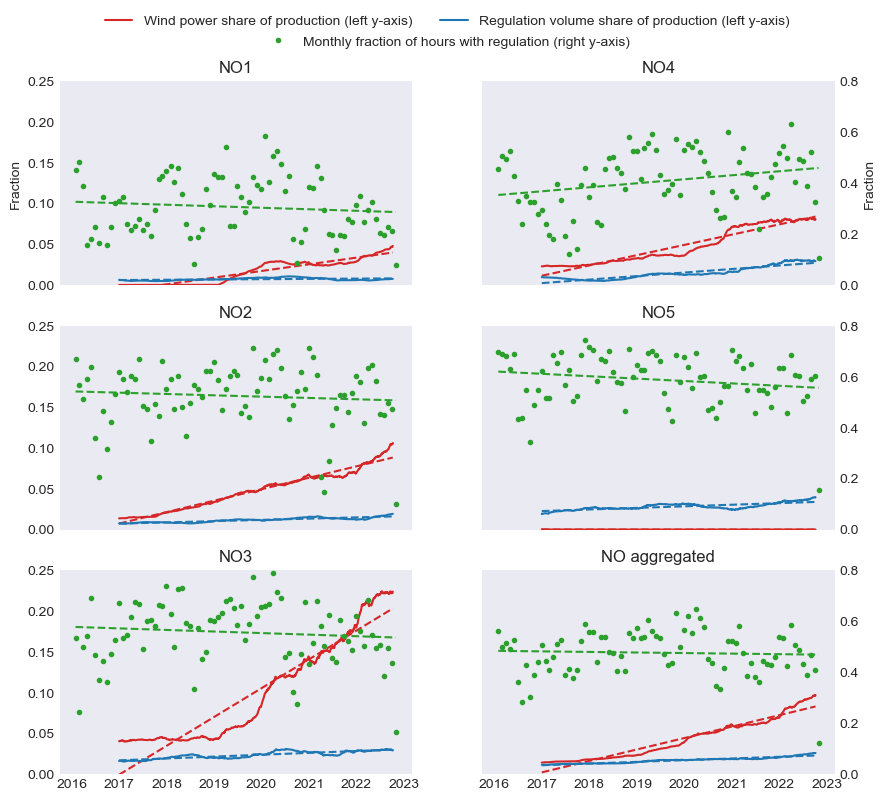

In [7]:
N=3
Nz=2
fig = plt.figure(figsize=(figwidth, 3*N))
axs = fig.subplots(N, Nz, sharex=True, sharey=False)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.12) 
row = 0
col = 0
for i in range(1,6):
    ratio = mean_wind[f'NO{i}_prod_Wind Onshore']/mean_prod[f'NO{i}_prod_sum']
    axs[row,col].plot(ratio, c=color_dic['prod'], label='Wind power share of production (left y-axis)')
    axs[row,col].plot(get_regression_line(ratio),'--', c=color_dic['prod'])
    line = get_regression_line(ratio)
    #print(f'Wind NO{i} yoy change: {(line[-1]-line[-8760])/line[-8760]}')

    ratio = regvolume[f'regulations_NO{i}']/mean_prod[f'NO{i}_prod_sum']
    axs[row,col].plot(ratio, c=color_dic['reg'], label='Regulation volume share of production (left y-axis)')
    axs[row,col].plot(get_regression_line(ratio),'--', c=color_dic['reg'])
    line = get_regression_line(ratio)
    #print(f'regvolume NO{i} yoy change: {(line[-1]-line[-8760])/line[-8760]}')

    axs2 = axs[row,col].twinx()
    axs2.plot(reg_hours[f'regulations_NO{i}']/730, '.',c=color_dic['other1'], 
                label='Monthly fraction of hours with regulation (right y-axis)')
    axs2.plot(get_regression_line(reg_hours[f'regulations_NO{i}']/730), '--', c=color_dic['other1'])
    line = get_regression_line(reg_hours[f'regulations_NO{i}']/730)
    #print(f'Reghours NO{i} yoy change: {(line[-1]-line[-12])/line[-12]}')

    axs[row,col].set_ylim([0,0.25])
    axs2.set_ylim([0,0.8])
    #if(row>0):
    #    axs[row,col].set_yticks([])
    #    axs2.set_yticks([])
    if(row==0 and col==0):
        axs2.set_yticks([])
    if(row==0 and col==1):
        axs[row,col].set_yticks([])
    if(col==0):
        axs2.set_yticks([])
    if(col==1):
        axs[row,col].set_yticks([])


    if(i==1):
        ax2legend = axs2
    lim = axs[row,col].get_ylim()[0]
    if(i==4):
        axs2.set_ylabel('Fraction')
    #if(lim<0):
    #    axs[row,col].set_ylim(bottom=-0.001)

    axs[row,col].set_title(f'NO{i}')
    row+=1
    if(row==3):
        col+=1
        row=0



ratio = mean_wind.sum(axis=1)/mean_prod.sum(axis=1)
axs[2,1].plot(ratio, c=color_dic['prod'], label='Wind power share of production')
axs[2,1].plot(get_regression_line(ratio),'--', c=color_dic['prod'])
line = get_regression_line(ratio)
#print(f'Wind NO yoy change: {(line[-1]-line[-8760])/line[-8760]}')

ratio = regvolume.sum(axis=1)/mean_prod.sum(axis=1)
axs[2,1].plot(ratio, c=color_dic['reg'], label='Regulation volume share of production')
axs[2,1].plot(get_regression_line(ratio),'--', c=color_dic['reg'])
line = get_regression_line(ratio)
#print(f'Regvolume NO yoy change: {(line[-1]-line[-8760])/line[-8760]}')

axs2 = axs[2,1].twinx()
axs2.plot(reg_hours.sum(axis=1)/(5*730), '.',c=color_dic['other1'], label='Monthly fraction of hours with regulation')
axs2.plot(get_regression_line(reg_hours.sum(axis=1)/(5*730)),'--', c=color_dic['other1'])
line = get_regression_line(reg_hours.sum(axis=1)/(5*730))
#print(f'Reghours NO yoy change: {(line[-1]-line[-12])/line[-12]}')

axs[2,1].set_title(f'NO aggregated')
axs[2,1].set_ylim([0,0.25])
axs2.set_ylim([0,0.8])
axs[2,1].set_yticks([])
#axs2.set_yticks([])
axs[0,0].legend(fontsize=10, loc='lower center', bbox_to_anchor=(1.1, 1.2),
          ncol=2, fancybox=True, shadow=True)
axs[0,0].set_ylabel('Fraction')

#axs[0,0].legend(loc='upper left', frameon=True)
ax2legend.legend(fontsize=10, loc='lower center', bbox_to_anchor=(1.1, 1.1),
          ncol=1, fancybox=True, shadow=True)
fig.savefig(f"figures/nature_of_volume/ratio_evolution.png", format='png', bbox_inches='tight')


## Sources of production

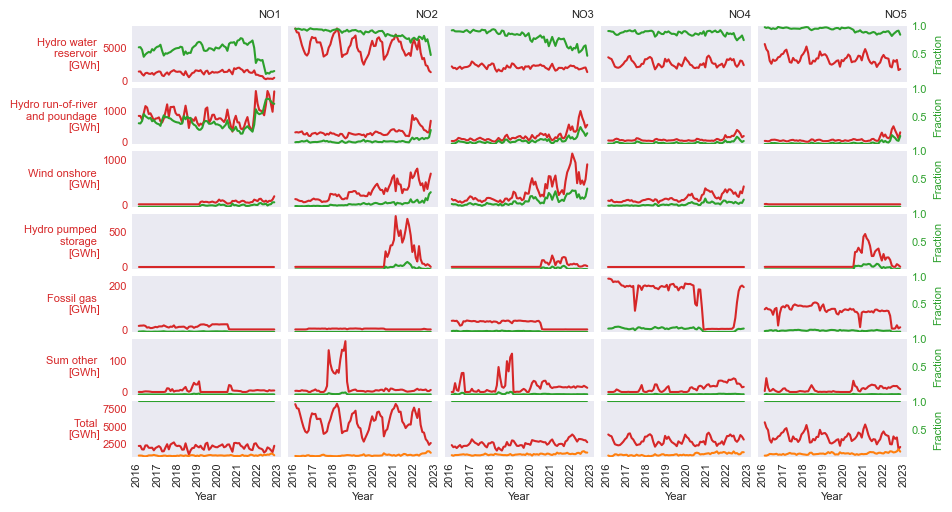

In [8]:
production_resampled = production_df.resample('M').mean()

#reg = df[["NO1","NO2", "NO3", "NO4", "NO5"]].copy()
#regulation_resampled = reg..abs().resample('M').mean()

reg = df[["regulations_NO1","regulations_NO2", "regulations_NO3", "regulations_NO4", "regulations_NO5"]].copy().replace(0, np.nan)
regulation_resampled = reg.resample('M').std()

plot_cats = ['Hydro Water Reservoir', 
             'Hydro Run-of-river and poundage',
             'Wind Onshore',
             'Hydro Pumped Storage',
             'Fossil Gas',
             'Sum other',
             'sum']

plot_labels = ['Hydro water \nreservoir', 
               'Hydro run-of-river \nand poundage',
               'Wind onshore', 
               'Hydro pumped \nstorage',
               'Fossil gas',
               'Sum other',
               'Total']


Nz = 5
N = len(plot_cats)
fig = plt.figure(figsize=(figwidth, 0.8*N))
axs = fig.subplots(N, Nz, sharex=True, sharey='row')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.12) 

for i in range(1, Nz+1):  # adding 1 to have space for legends
    NO_prod = production_resampled.filter(regex=f"NO{i}_prod").copy()
    
    not_in_cols = [f'NO{i}_prod_'+cat for cat in plot_cats + ['sum']]  # Column names to check if they are in plot list
    other_cols = [col for col in  NO_prod.columns if col not in not_in_cols]  # All other columns will be summed up
    NO_prod[f'NO{i}_prod_Sum other'] = NO_prod[other_cols].sum(axis=1)
    
    NO_prod_frac = NO_prod.copy().div(NO_prod[f'NO{i}_prod_sum'], axis=0)  # Computing fractions to be plotted
    NO_reg_frac = regulation_resampled[f'regulations_NO{i}'].div(NO_prod[f'NO{i}_prod_sum'], axis=0)
    plot_cats_names = plot_cats
    plot_cols = [f'NO{i}_prod_'+cat for cat in plot_cats_names]
       
    for k in range(N):
        ax = axs[k, i-1]
        twinax = ax.twinx()
        twinax.set_ylim(0, 1)
#        twinax.set_yticklabels([])

        if plot_cols[k] in NO_prod.columns:
            
            if plot_cats_names[k]=='sum':
                c1 = color_dic['prod']
                twinax.plot(NO_reg_frac, color=color_dic['other2'])            
                #twinax.plot(regulation_resampled[f'NO{i}'], color=color_dic['other1'])            

            else:
                c1 = color_dic['prod']
            ax.plot(NO_prod[plot_cols[k]], color=c1)
            twinax.plot(NO_prod_frac[plot_cols[k]], color=color_dic['other1'])        
        else:
            dummyx = [NO_prod.index.min(), NO_prod.index.max()]
            dummyy = [0, 0]
            ax.plot(dummyx, dummyy, color=color_dic['prod'])

        for t in ax.get_yticklabels():
            t.set_color(color=c1)
            t.set_fontsize(fontsize)
#                for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
#        label.set_fontsize(fontsize)

        if plot_cats_names[k]=='sum':
            ax.set_xlabel('Year', fontsize=fontsize)
            for t in ax.get_xticklabels():
                t.set_fontsize(fontsize)
                t.set_rotation(90)

        if k==0:
            ax.set_title(f'NO{i}', loc='right', fontsize=fontsize)
            
        if i==1:
            twinax.text(pd.to_datetime('2014-03-01'), 0.5, f'{plot_labels[k]} \n[GWh]', color=c1, fontsize=fontsize, 
                        verticalalignment='center', horizontalalignment='right')
        
        if i==Nz:
            twinax.set_ylabel('Fraction', color=color_dic['other1'], fontsize=fontsize)
            twinax.set_yticks([0.5 ,1])
            for t in twinax.get_yticklabels():
                t.set_color(color_dic['other1'])
                t.set_fontsize(fontsize)
        else:
            twinax.set_yticklabels([])

fig.savefig(f"figures/nature_of_volume/production_all.png", format='png', bbox_inches='tight')


## Normalized DFT on data

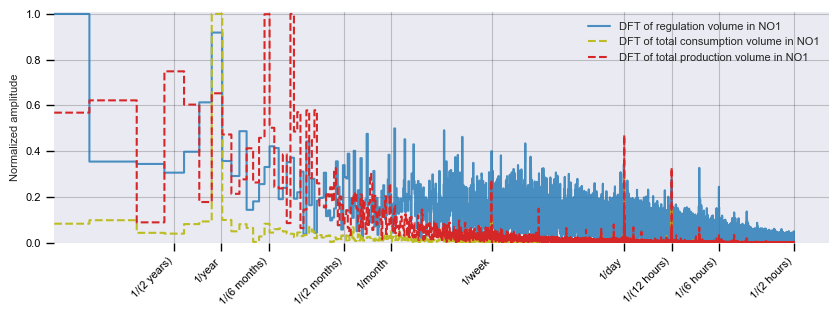

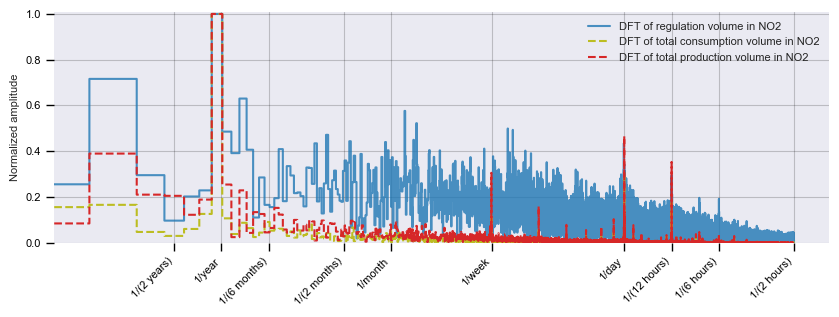

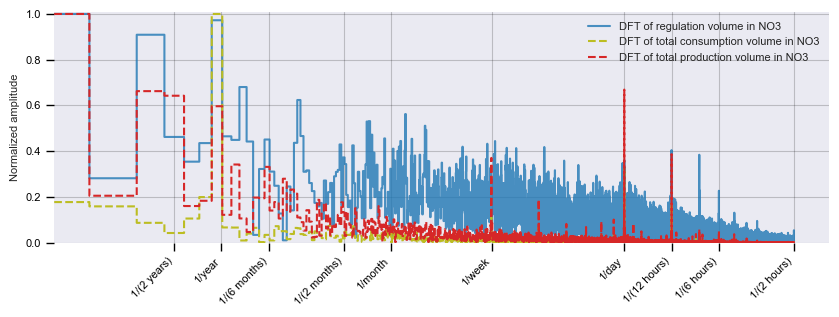

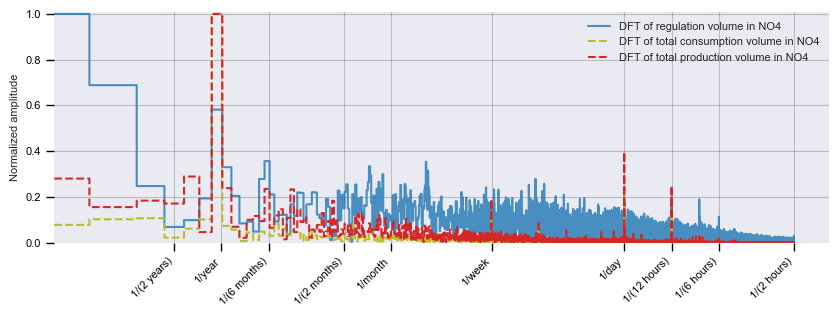

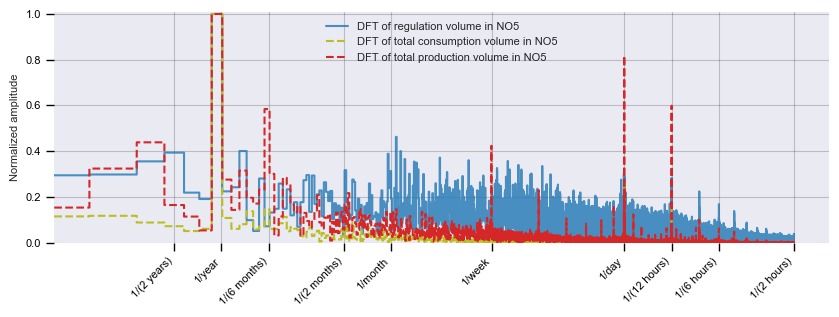

In [9]:
NO_reg_zones = [f'regulations_{zone}' for zone in NO_zones]
NO_cons_zones = [f'consumption_{zone}'for zone in NO_zones]
NO_prod_zones = [f'production_{zone}'for zone in NO_zones]

labels = ['1/(2 years)', '1/year', '1/(6 months)', '1/(2 months)', '1/month', '1/week', '1/day', '1/(12 hours)', '1/(6 hours)', '1/(2 hours)']
ticks =  [0.5, 1, 2, 6, 12, 53, 365.2524, 2*365.2524, 4*365.2524, 12*365.2524]

zone_index=1
for reg_zone, cons_zone, prod_zone in zip(NO_reg_zones, NO_cons_zones, NO_prod_zones):
    plt.figure(figsize=(figwidth, 3))
#-------------------- REGULATION VOLUME ---------------------
    reg_vol_fft = df[reg_zone].to_numpy()

    fft = tf.signal.rfft(reg_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = reg_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, alpha=0.8 ,linestyle="-", 
            label="DFT of regulation volume in NO"+str(zone_index), c=color_dic['reg'])


#-------------------- CONSUMPTION ---------------------
    prod_vol_fft = df[cons_zone].to_numpy()

    fft = tf.signal.rfft(prod_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = prod_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, linestyle="--", 
            label="DFT of total consumption volume in NO"+str(zone_index), c=color_dic['cons'])


#-------------------- PRODUCTION ---------------------
    prod_vol_fft = df[prod_zone].to_numpy()

    fft = tf.signal.rfft(prod_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = prod_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, linestyle="--", 
            label="DFT of total production volume in NO"+str(zone_index), c=color_dic['prod'])
    plt.xscale('log')
    plt.ylim(0, 1.01)
    plt.xticks(ticks, labels=labels, rotation = 45,ha="right" ,fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.tick_params(direction='out', length=6, width=1, colors='black',
               grid_color='black', grid_alpha=0.2)
    plt.grid()
    _ = plt.ylabel('Normalized amplitude', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
 
    plt.savefig(f"figures/nature_of_volume/DFT_{reg_zone}.png",  bbox_inches='tight')
    zone_index=zone_index+1

## Moving average

0
1
2
3
4


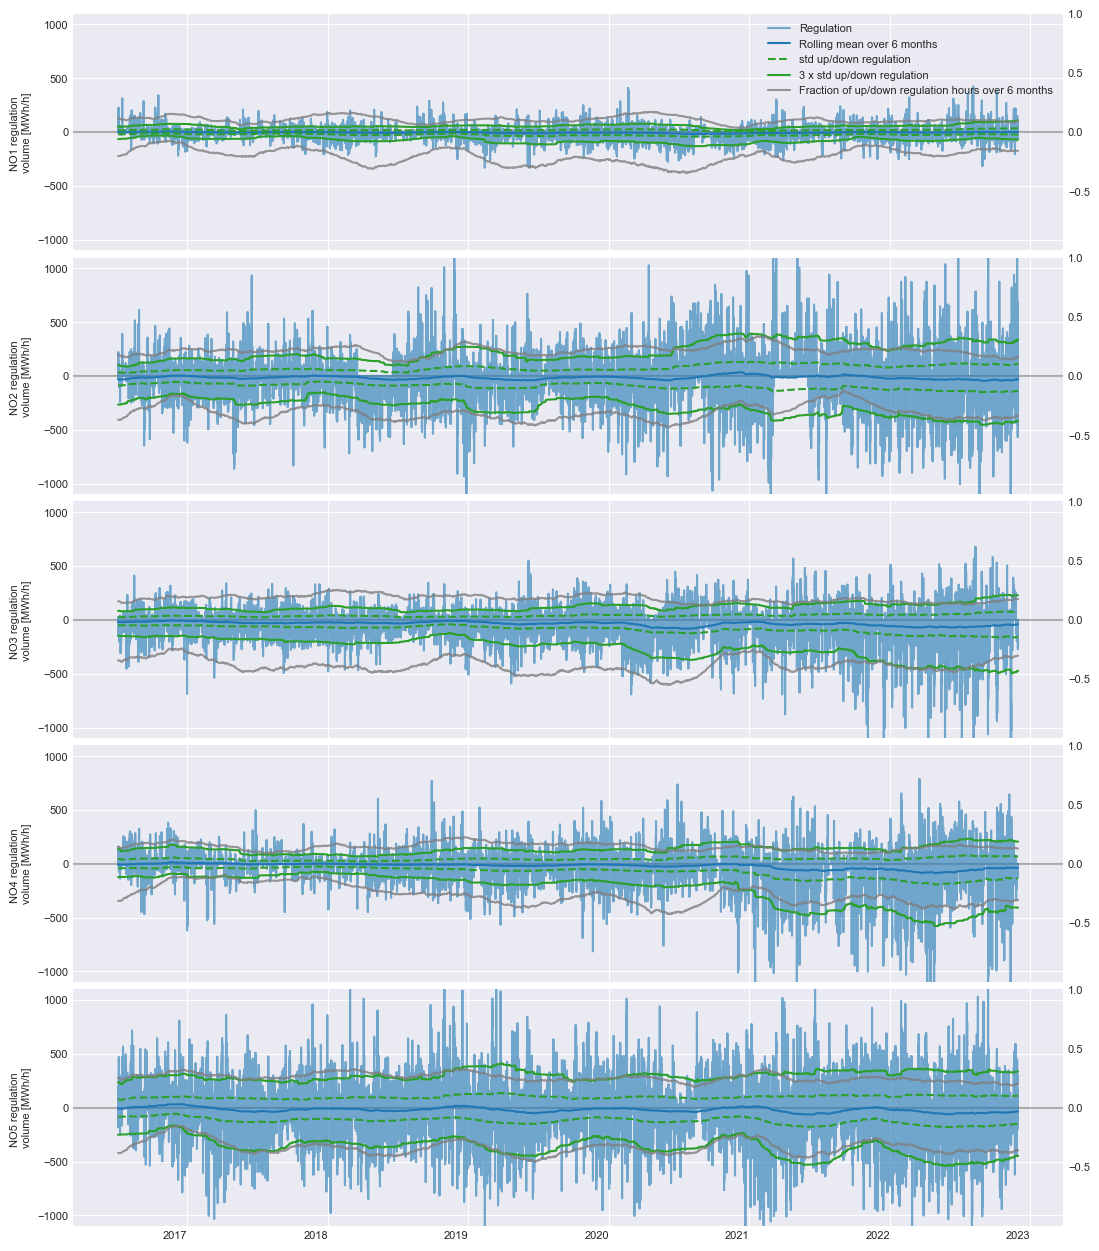

In [10]:
NO_reg_zones = [f'regulations_{zone}' for zone in NO_zones]
Nmonths = 6
window_size = 24*31*Nmonths #8777

reg_zones_analysis = ["year"] + NO_reg_zones
reg_zones_analysis_new = ["year", "NO1 regulation volume", "NO2 regulation volume", "NO3 regulation volume", "NO4 regulation volume", "NO5 regulation volume"]
reg_vol_df = df[reg_zones_analysis].copy()
reg_vol_df.columns = reg_zones_analysis_new
#reg_vol_df = reg_vol_df[reg_vol_df["year"] > 2021]

N=5
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
ax[0].set_ylim(-1100,1100)

for i in range(0, 5):
        print(i)
        NO_reg_vol_series = reg_vol_df[f"NO{i+1} regulation volume"]
        NO_nonzero_series = NO_reg_vol_series.copy()
#        NO_reg_vol_series_week = NO_reg_vol_series.resample('W').sum()
        NO_reg_vol_series.name = ""
        windows = NO_reg_vol_series.rolling(window_size)
        moving_averages = windows.mean()
##        moving_skew = windows.skew()
##        moving_kurt = windows.kurt()


        ax[i].axhline(0, color=color_dic['helper'], alpha=0.6)

        NO_reg_vol_series[window_size:].plot(alpha=0.6, c=color_dic['reg'], 
                                                     ax=ax[i], grid='True', label='Regulation')

        moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                    label=f"Rolling mean over {Nmonths} months", grid='True')

        NO_reg_vol_series_up = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_down = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_up[NO_reg_vol_series_up<0] = 0
        NO_reg_vol_series_down[NO_reg_vol_series_down>0] = 0        
        NO_reg_vol_series_abs = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_abs = NO_reg_vol_series_abs.abs()
        
        NO_reg_vol_series_up.name = ""
        windows2 = NO_reg_vol_series_up.rolling(window_size)
        moving_averages2 = windows2.mean()
        moving_std_up = windows2.std()
        moving_std_up3 = moving_std_up*3
        moving_zeros_up = windows2.apply(lambda x: (x==0).sum())
        moving_up_frac = (window_size - moving_zeros_up)/window_size

        NO_reg_vol_series_down.name = ""
        windows3 = NO_reg_vol_series_down.rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = -windows3.std()
        moving_std_down3 = moving_std_down*3
        moving_zeros_down = windows3.apply(lambda x: (x==0).sum())
        moving_down_frac = -(window_size - moving_zeros_down)/window_size
        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], label="std up/down regulation", grid='True', linestyle='dashed')
        ax[i] = moving_std_down[window_size:].plot(c=color_dic['other1'], ax=ax[i], grid='True', linestyle='dashed')

        ax[i] = moving_std_up3[window_size:].plot(c=color_dic['other1'], ax=ax[i], label="3 x std up/down regulation", grid='True')
        ax[i] = moving_std_down3[window_size:].plot(c=color_dic['other1'], ax=ax[i], grid='True')

        ax[i].set_ylabel(f"NO{i+1} regulation \nvolume [MWh/h]", fontsize=fontsize)
        ax[i].set_xlabel("")
        ax[i].tick_params(axis='x', labelrotation=0)

        ax2 = ax[i].twinx()
        ax2.set_ylim(-1,1)
##        ax2 = moving_skew[window_size:].plot(c='yellow', ax=ax2, 
##                                                    label=f"Rolling mean over {Nmonths} months", grid='True')
##        ax2 = moving_kurt[window_size:].plot(c='black', ax=ax2, 
##                                                    label=f"Rolling mean over {Nmonths} months", grid='True')
#        ax2 = moving_up_frac[window_size:].plot(c=color_dic['helper'], ax=ax2, alpha=0.8,
#                                                label=f"Fraction of non-zero regulation hours over {Nmonths} months", grid='False')
#        ax2 = moving_down_frac[window_size:].plot(c=color_dic['helper'], ax=ax2, alpha=0.8,
#                                                label=f"Fraction of non-zero regulation hours over {Nmonths} months", grid='False')

        ax2.plot(moving_up_frac[window_size:], c=color_dic['helper'], alpha=0.8,
                       label=f"Fraction of up/down regulation hours over {Nmonths} months")
        ax2.plot(moving_down_frac[window_size:], c=color_dic['helper'], alpha=0.8)

        ax2.grid(False)
        ax2.set_yticks([-0.5, 0, 0.5, 1.0])
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels() + ax2.get_yticklabels()):
            label.set_fontsize(fontsize)
 
        if i==0:
            h1, l1 = ax[i].get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            plt.legend(h1+h2, l1+l2, fontsize=fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.03, 
                    hspace=0.03)

plt.savefig(f"figures/nature_of_volume/historic_volumes.png",  bbox_inches='tight')

#Hours with up-regulation, hours with down-regulation in volume plot???


### Time differences for checking stationarity

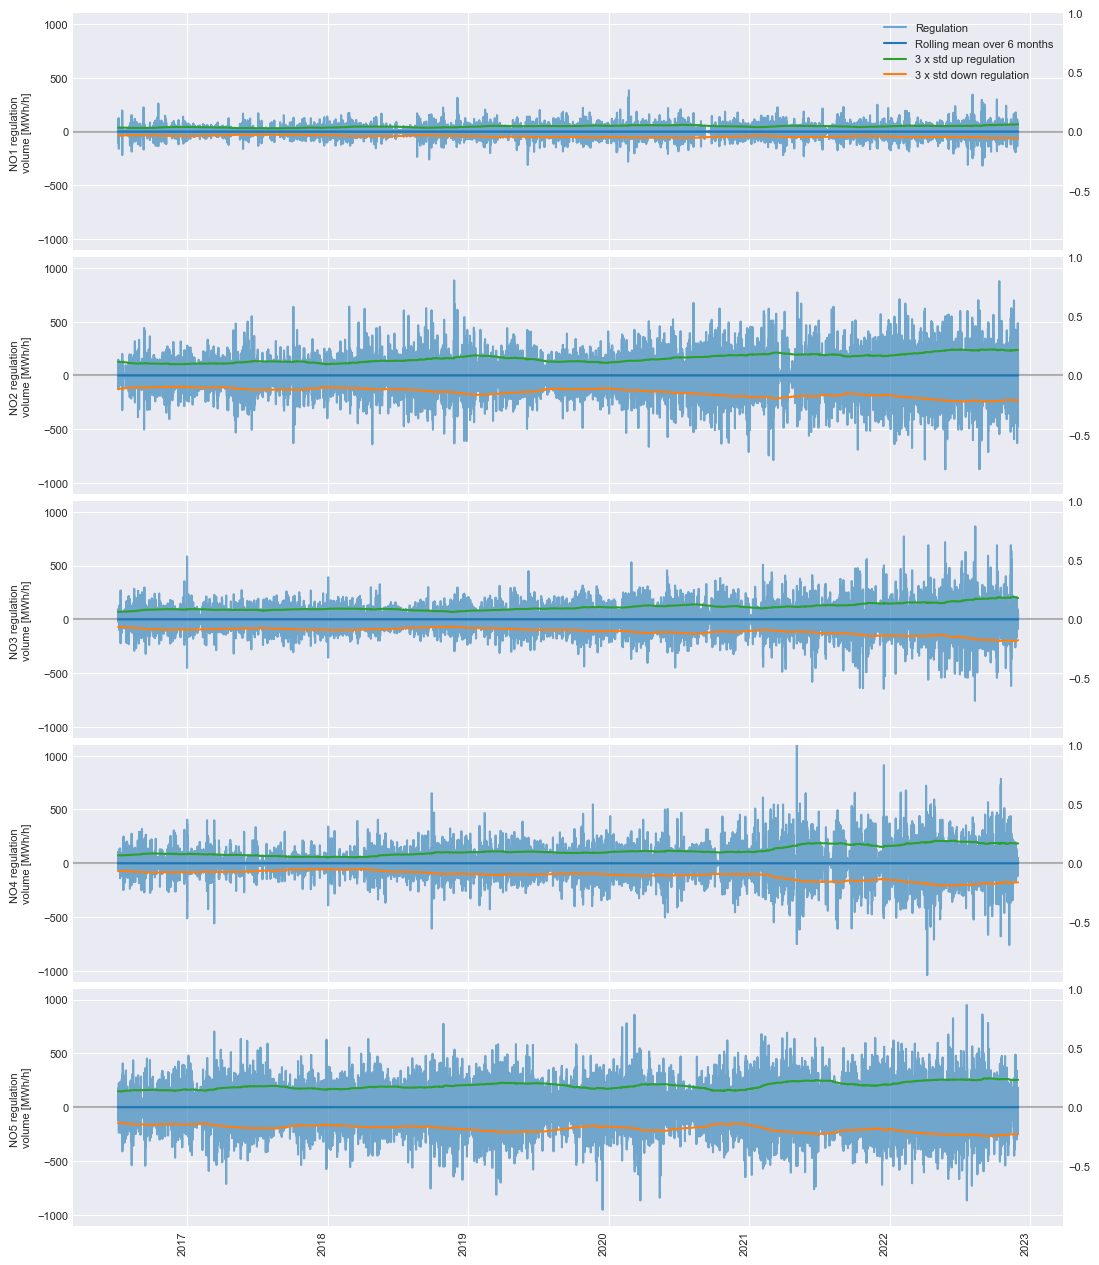

In [11]:
#Time differences

Nmonths = 6
window_size = 24*31*Nmonths #8777
NO_reg_zones = [f'regulations_{zone}' for zone in NO_zones]
reg_zones_analysis = ["year"] + NO_reg_zones
reg_zones_analysis_new = ["year", "NO1 regulation volume", "NO2 regulation volume", "NO3 regulation volume", "NO4 regulation volume", "NO5 regulation volume"]
reg_vol_df = df[reg_zones_analysis].copy().diff()
reg_vol_df.columns = reg_zones_analysis_new
#reg_vol_df = reg_vol_df[reg_vol_df["year"] < 2022]

N=5
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
ax[0].set_ylim(-1100,1100)

for i in range(0, N):
        NO_reg_vol_series = reg_vol_df[f"NO{i+1} regulation volume"]
        NO_nonzero_series = NO_reg_vol_series.copy()
        NO_reg_vol_series.name = ""
        windows = NO_reg_vol_series.rolling(window_size)
        moving_averages = windows.mean()

        # counting hours with non-zero regulation per window
        moving_zeros = windows.apply(lambda x: (x==0).sum())
        moving_nonzero_frac = (window_size - moving_zeros)/window_size

        ax[i].axhline(0, color=color_dic['helper'], alpha=0.6)

        ax[i] = NO_reg_vol_series[window_size:].plot(alpha=0.6, c=color_dic['reg'], 
                                                     ax=ax[i], grid='True', label='Regulation')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                    label=f"Rolling mean over {Nmonths} months", grid='True')
        ax2 = ax[i].twinx()
        ax2.set_ylim(-1,1)

        NO_reg_vol_series_up = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_down = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_up[NO_reg_vol_series_up<0] = 0
        NO_reg_vol_series_down[NO_reg_vol_series_down>0] = 0        
        NO_reg_vol_series_abs = reg_vol_df[f"NO{i+1} regulation volume"].copy()
        NO_reg_vol_series_abs = NO_reg_vol_series_abs.abs()
        
        NO_reg_vol_series_up.name = ""
        windows2 = NO_reg_vol_series_up.rolling(window_size)
        moving_averages2 = windows2.mean()
        moving_std_up = windows2.std()*3
        NO_reg_vol_series_down.name = ""
        windows3 = NO_reg_vol_series_down.rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = windows3.std()*-3
        NO_reg_vol_series_abs.name = ""
        windows4 = NO_reg_vol_series_abs.rolling(window_size)
        moving_averages4 = windows4.mean()
        moving_std_abs_pos = windows4.std()*3
        moving_std_abs_neg = windows4.std()*-3
        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], label="3 x std up regulation", grid='True')
        ax[i] = moving_std_down[window_size:].plot(c=color_dic['other2'], ax=ax[i], label="3 x std down regulation", grid='True')

        ax[i].set_ylabel(f"NO{i+1} regulation \nvolume [MWh/h]", fontsize=fontsize)
        ax[i].set_xlabel("")
        ax[i].tick_params(axis='x', labelrotation=90)

        ax2.grid(False)
        ax2.set_yticks([-0.5, 0, 0.5, 1.0])
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels() + ax2.get_yticklabels()):
            label.set_fontsize(fontsize)
 
        if i==0:
            h1, l1 = ax[i].get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            plt.legend(h1+h2, l1+l2, fontsize=fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.03, 
                    hspace=0.03)

plt.savefig(f"figures/nature_of_volume/historic_volumes_diff.png",  bbox_inches='tight')

#Hours with up-regulation, hours with down-regulation in volume plot???


### Regulation capacities over time

Volume of regulation bids

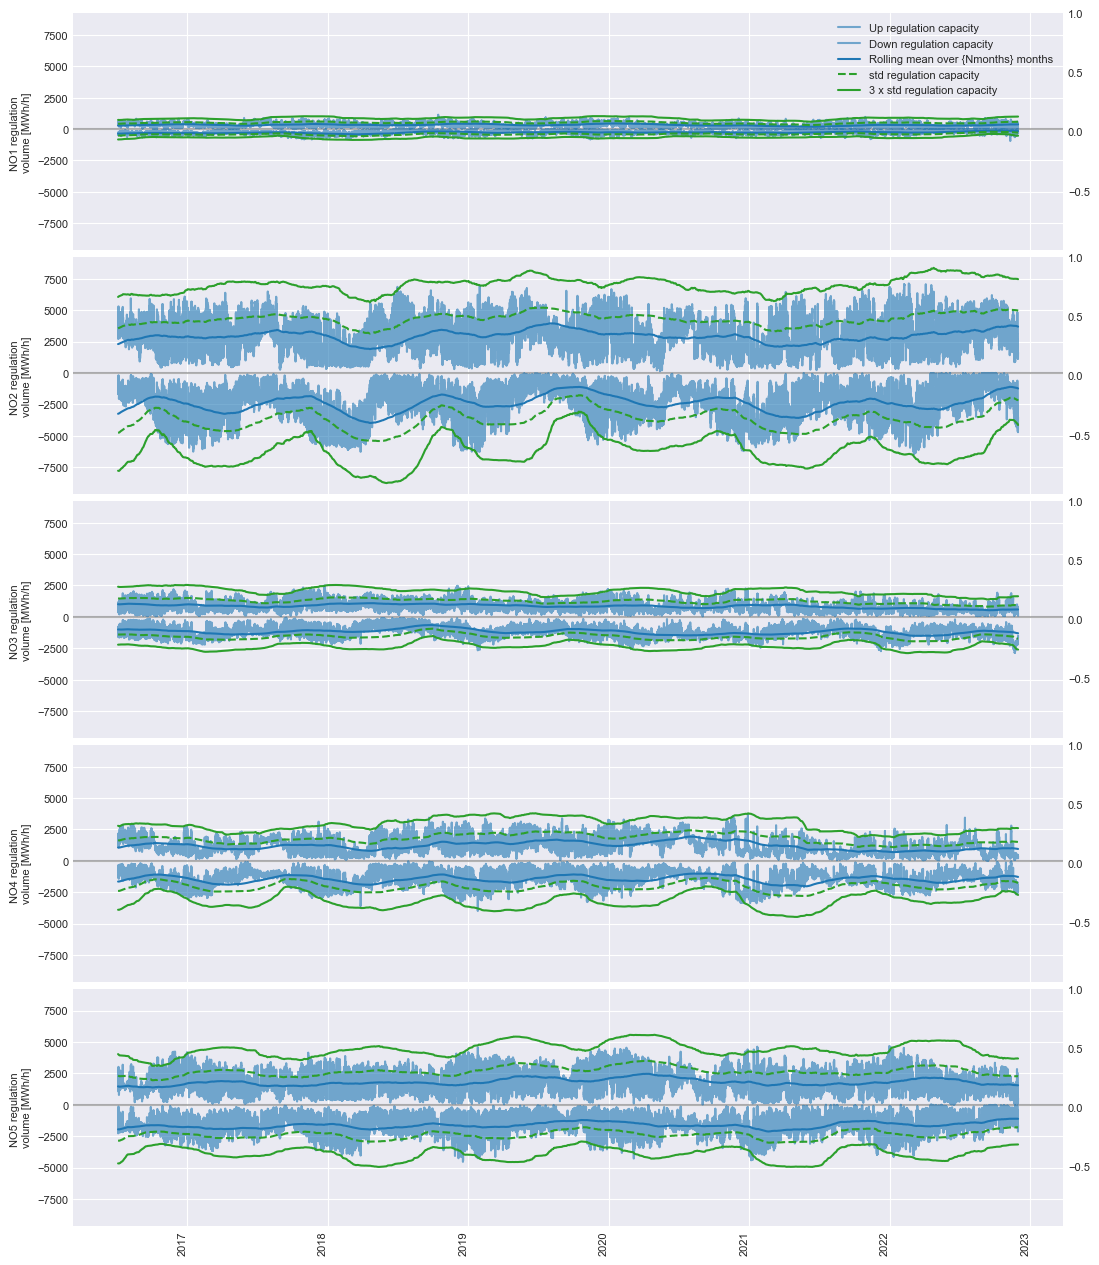

In [12]:
NO_regup_zones = [f'capacity_regulations_up{zone}' for zone in NO_zones]
NO_regdown_zones = [f'capacity_regulations_down{zone}' for zone in NO_zones]
#NO_sell_zones = [f'day_ahead_{zone}' for zone in NO_zones] + [f'day_ahead_{zone}' for zone in NO_zones]

Nmonths = 6
window_size = 24*31*Nmonths #8777


reg_zones_analysis = ["year"] + NO_regup_zones + NO_regdown_zones
reg_zones_analysis_new = ["year"] + [f"{zone} up regulation capacity" for zone in NO_zones] + [f"{zone} down regulation capacity" for zone in NO_zones]
reg_vol_df = df[reg_zones_analysis].copy()
reg_vol_df.columns = reg_zones_analysis_new

#reg_vol_df = reg_vol_df[reg_vol_df.year < 2017]


N=5
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
#ax[0].set_ylim(0,4000)

for i in range(0, N):

        ax[i].axhline(0, color=color_dic['helper'], alpha=0.6)

        NO_reg_vol_series_up = reg_vol_df[f"NO{i+1} up regulation capacity"].copy()
        NO_reg_vol_series_down = -reg_vol_df[f"NO{i+1} down regulation capacity"].copy()
        
        NO_reg_vol_series_up.name = ""
        windows2 = NO_reg_vol_series_up.rolling(window_size)
        moving_averages2 = windows2.mean()
        moving_std_up = windows2.std()
        plot_std_up = moving_std_up + moving_averages2
        plot_3std_up = moving_std_up*3 + moving_averages2
        NO_reg_vol_series_down.name = ""
        windows3 = NO_reg_vol_series_down.rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = -windows3.std()
        plot_std_down = moving_std_down + moving_averages3
        plot_3std_down = moving_std_down*3 + moving_averages3
        
        ax[i] = NO_reg_vol_series_up[window_size:].plot(alpha=0.6, c=color_dic['reg'], 
                                                     ax=ax[i], grid='True', label='Up regulation capacity')

        ax[i] = NO_reg_vol_series_down[window_size:].plot(alpha=0.6, c=color_dic['reg'], 
                                                     ax=ax[i], grid='True', label='Down regulation capacity')


        ax[i] = moving_averages2[window_size:].plot(c=color_dic['reg'], ax=ax[i], label="Rolling mean over {Nmonths} months", grid='True')
        ax[i] = moving_averages3[window_size:].plot(c=color_dic['reg'], ax=ax[i], grid='True')

        ax[i] = plot_std_down[window_size:].plot(c=color_dic['other1'], ax=ax[i], label="std regulation capacity", grid='True', linestyle='dashed')
        ax[i] = plot_3std_down[window_size:].plot(c=color_dic['other1'], ax=ax[i], label="3 x std regulation capacity", grid='True')

        ax[i] = plot_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], grid='True', linestyle='dashed')
        ax[i] = plot_3std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], grid='True')

        ax[i].set_ylabel(f"NO{i+1} regulation \nvolume [MWh/h]", fontsize=fontsize)
        ax[i].set_xlabel("")
        ax[i].tick_params(axis='x', labelrotation=90)
        ax2 = ax[i].twinx()
        ax2.set_ylim(-1,1)

        ax2.grid(False)
        ax2.set_yticks([-0.5, 0, 0.5, 1.0])
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels() + ax2.get_yticklabels()):
            label.set_fontsize(fontsize)
 
        if i==0:
            h1, l1 = ax[i].get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            plt.legend(h1+h2, l1+l2, fontsize=fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.03, 
                    hspace=0.03)

plt.savefig(f"figures/nature_of_volume/historic_up_capacities.png",  bbox_inches='tight')


## Histograms regulation volume

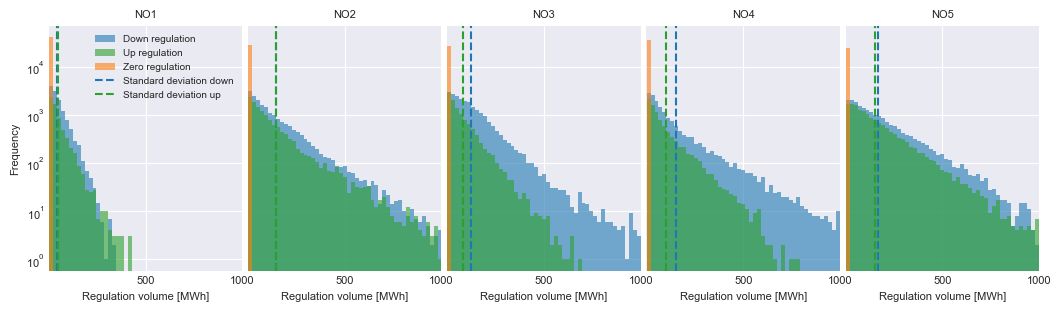

In [13]:
im_volumes_NO = im_volumes_df.loc[:, "NO1 regulation volume":"NO5 regulation volume"]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(figwidth, 2.5), sharey=True, sharex=True)

Nmax = 1000
Nbins = 50
bins = np.linspace(0, Nmax, Nbins)
ax[0].set_xlim(-1, 1000)
ax[0].set_yscale('log')

for i in range(5):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(fontsize)

    ax[i].grid(axis='x')
    ax[i].set_title(f'NO{i+1}', fontsize=fontsize)   
    ax[i].set_xlabel(f'Regulation volume [MWh]', fontsize=fontsize)

    data_val = im_volumes_NO.iloc[:,i].copy()
    data_zero = data_val[data_val == 0].copy()
    data_upper = data_val[data_val > 0].copy()
    data_lower = data_val[data_val < 0].abs().copy()

    ax[i] = data_lower.hist(bins=bins, ax=ax[i], alpha=0.6, label='Down regulation', color=color_dic['reg'])
    ax[i] = data_upper.hist(bins=bins, ax=ax[i], alpha=0.6, label='Up regulation', color=color_dic['other1'])
    ax[i] = data_zero.hist(bins=bins, ax=ax[i], alpha=0.6, label='Zero regulation', color=color_dic['other2'])

    std_lower = data_lower.std(axis=0)
    std_upper = data_upper.std(axis=0)

    ax[i].axvline(std_lower, linestyle="--", color=color_dic['reg'], alpha=1, label="Standard deviation down")
    ax[i].axvline(std_upper, linestyle="--", color=color_dic['other1'], alpha=1, label="Standard deviation up")

    if i == 0:
        ax[0].legend(loc="upper right", fontsize=0.9*fontsize)
        ax[0].set_ylabel('Frequency', fontsize=fontsize)

    ax[i].set_xticks([500, 1000])

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
#fig.tight_layout()
fig.savefig(f"figures/nature_of_volume/target_volume_histogram.png",  bbox_inches='tight')

## Histograms regulation fraction

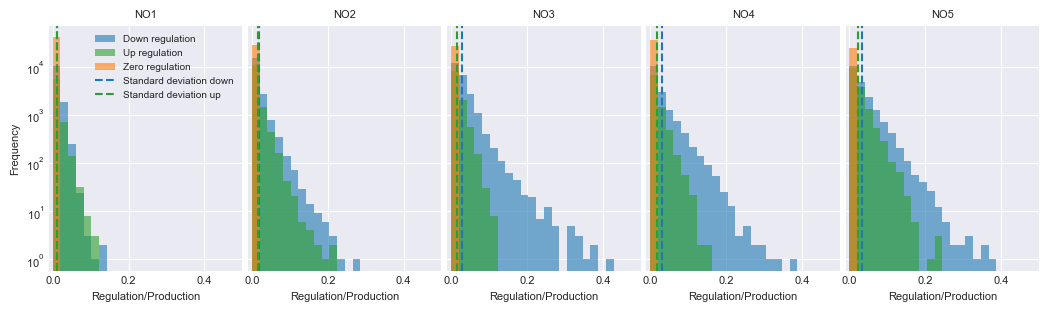

In [14]:
im_prod_NO = df[NO_prod_zones]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(figwidth, 2.5), sharey=True, sharex=True)

Nmax = 1
Nbins = 50
bins = np.linspace(0, Nmax, Nbins)
ax[0].set_xlim(-0.01, 0.5)
ax[0].set_yscale('log')


for i in range(5):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(fontsize)

    ax[i].grid(axis='x')
    ax[i].set_title(f'NO{i+1}', fontsize=fontsize)   
    ax[i].set_xlabel(f'Regulation/Production', fontsize=fontsize)

    data_val = im_volumes_NO.iloc[:,i].copy()/im_prod_NO.iloc[:,i].copy()
    data_zero = data_val[data_val == 0].copy()
    data_upper = data_val[data_val > 0].copy()
    data_lower = data_val[data_val < 0].abs().copy()

    ax[i] = data_lower.hist(bins=bins, ax=ax[i], alpha=0.6, label='Down regulation', color=color_dic['reg'])
    ax[i] = data_upper.hist(bins=bins, ax=ax[i], alpha=0.6, label='Up regulation', color=color_dic['other1'])
    ax[i] = data_zero.hist(bins=bins, ax=ax[i], alpha=0.6, label='Zero regulation', color=color_dic['other2'])

    std_lower = data_lower.std(axis=0)
    std_upper = data_upper.std(axis=0)

    ax[i].axvline(std_lower, linestyle="--", color=color_dic['reg'], alpha=1, label="Standard deviation down")
    ax[i].axvline(std_upper, linestyle="--", color=color_dic['other1'], alpha=1, label="Standard deviation up")

    if i == 0:
        ax[0].legend(loc="upper right", fontsize=0.9*fontsize)
        ax[0].set_ylabel('Frequency', fontsize=fontsize)


plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
#fig.tight_layout()
fig.savefig(f"figures/nature_of_volume/target_volume_histogram_percentage.png",  bbox_inches='tight')

## Autocorrelation

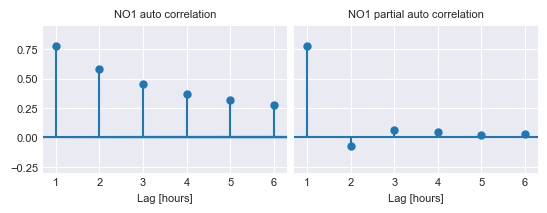

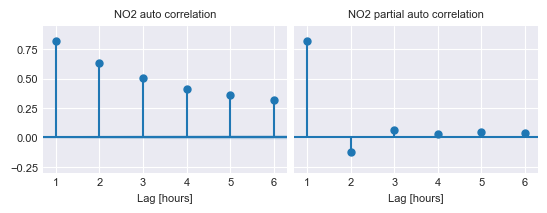

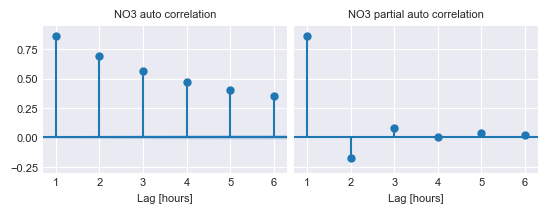

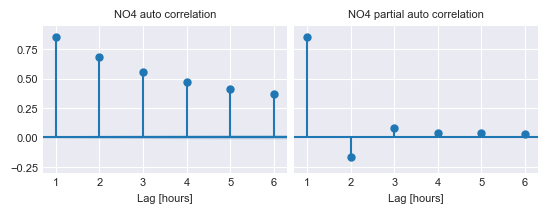

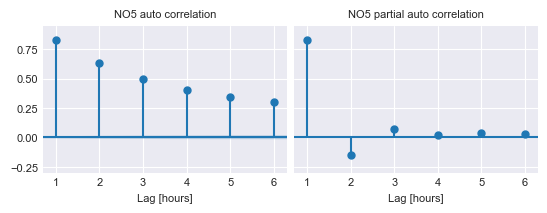

In [15]:
reg_zones_analysis = NO_reg_zones
reg_vol_df = df[reg_zones_analysis].copy()
nbf_lags = 6
N, M = figwidth/2, 1.5

for i in range(1,6):
    reg_vol = reg_vol_df[f"regulations_NO{i}"].to_numpy()
    fig, ax = plt.subplots(ncols=2, figsize=(N, M), sharey=True)
    
    for k in [0,1]:
        ax[k].set_xlabel('Lag [hours]', fontsize=fontsize)
        ax[k].set_xticks(np.arange(nbf_lags+1))
        ax[k].set_xlim(0.7, nbf_lags+0.3)
        ax[k].grid()

    acfax = plot_acf(reg_vol, lags=nbf_lags, fft=False, ax=ax[0])
    pacfax = plot_pacf(reg_vol, lags=nbf_lags, ax=ax[1])

    ax[0].set_ylim(-0.3, 0.95)
    ax[0].set_title(f"NO{i} auto correlation", fontsize=fontsize)
    ax[1].set_title(f"NO{i} partial auto correlation", fontsize=fontsize)
    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() + 
                  ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(fontsize)

    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)


    fig.savefig(f"figures/autocorrelations/acf_volume_auto_corr_NO{i}.png", bbox_inches="tight")
    plt.show()

## 2019 example patterns

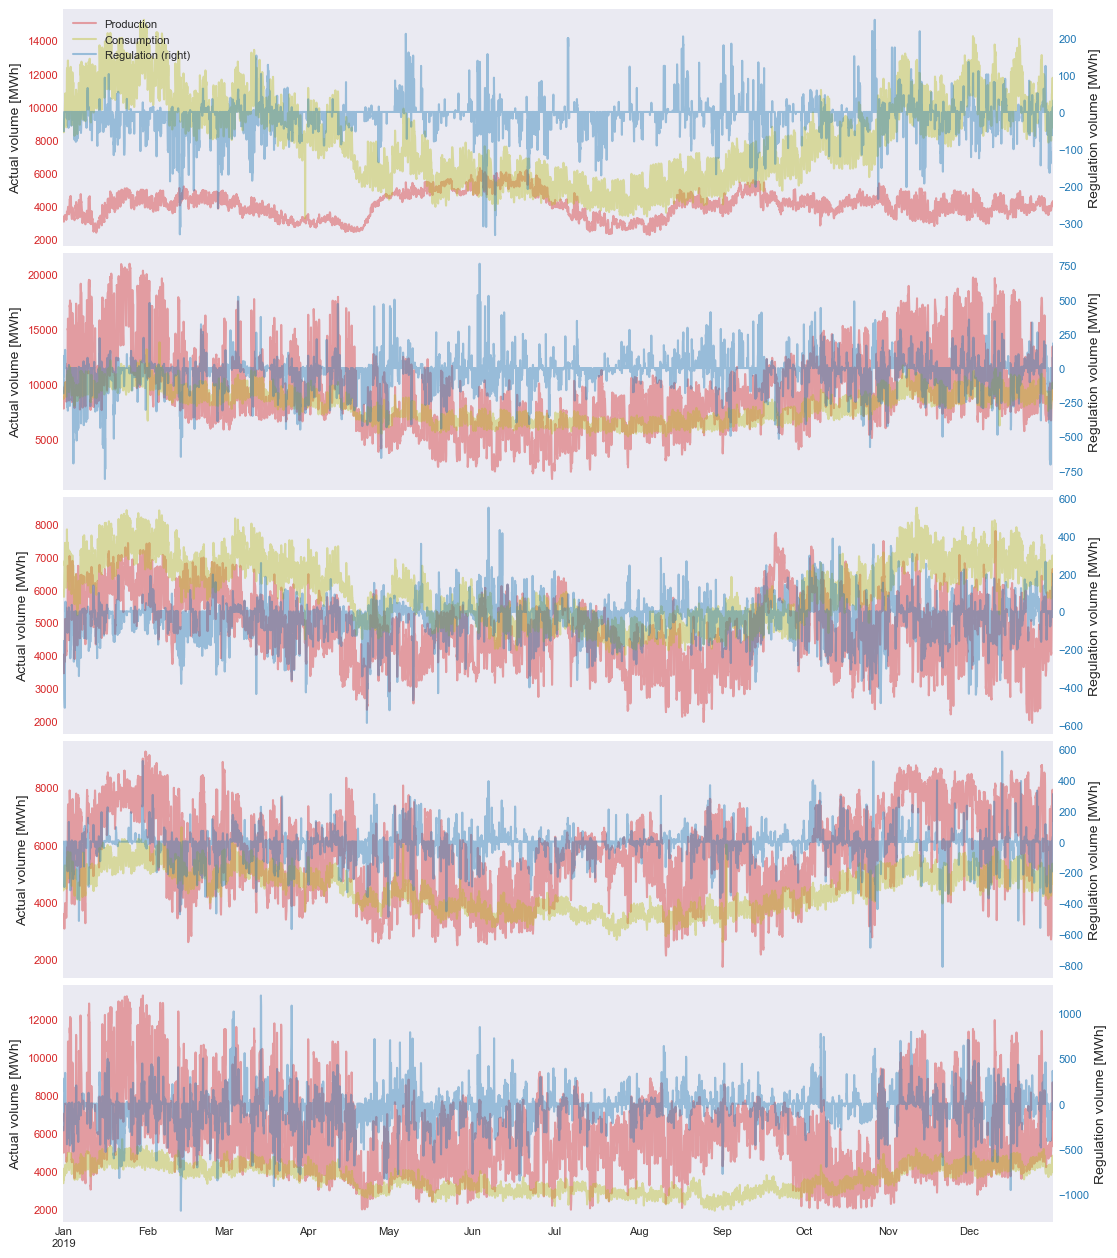

In [16]:
df_copy = df.copy()[df["year"]==2019]

#Turn into one figure to illustrate how different the regions are? Or just show two zones? 
#One with dominating production and one with dominating consumption?

Nplots = 5
fig, ax = plt.subplots(Nplots, figsize=(figwidth, 2.5*Nplots), sharex=True)

for i in range(Nplots):
    cols = ["year", f"production_NO{i+1}", f"regulations_NO{i+1}", f"consumption_NO{i+1}"] 
    #seasonal fluctuation is more clear with NO{i}_buy than NO{i}_prod
    data_df = df_copy[cols].copy()

    ax1 = data_df[f"production_NO{i+1}"].plot(ax=ax[i], xlabel="", ylabel=f"Actual volume [MWh]", 
                                        label=f'Production', color=color_dic['prod'], alpha=0.4, 
                                        fontsize=fontsize)
    
    ax1.tick_params(axis='y', colors = color_dic['prod'])

    ax1 = data_df[f"consumption_NO{i+1}"].plot(ax=ax1, xlabel="", label=f'Consumption',
                                      color=color_dic['cons'], alpha=0.4, fontsize=fontsize)

    ax2 = data_df[f"regulations_NO{i+1}"].plot(ax=ax1, secondary_y=True, xlabel="", 
                                ylabel="Regulation volume [MWh]", label=f'Regulation',
                                fontsize=fontsize, alpha=0.4)
    ax2.tick_params(axis='y', colors = color_dic['reg'])

    # Getting handles and legends from both axes
    if i==0:
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        plt.legend(h1+h2, l1+l2, fontsize=fontsize)
    
plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.03, 
                    hspace=0.03)

fig.savefig(f"figures/nature_of_volume/periodicity_combined_volume.png", bbox_inches='tight')


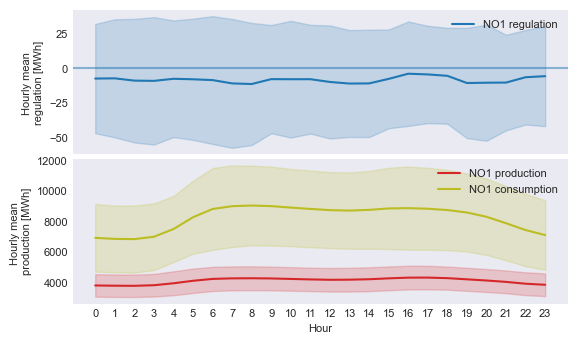

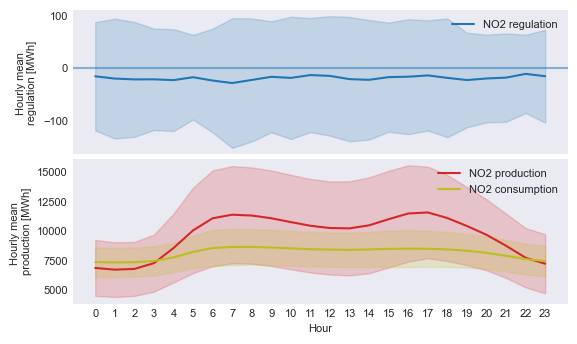

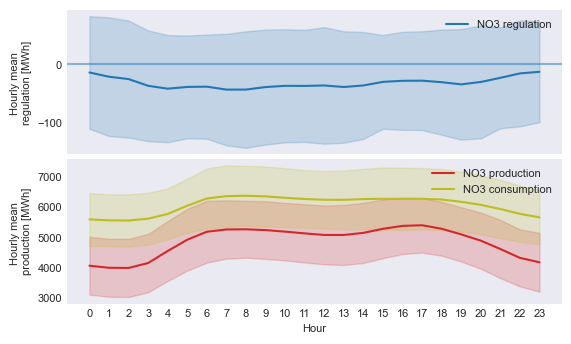

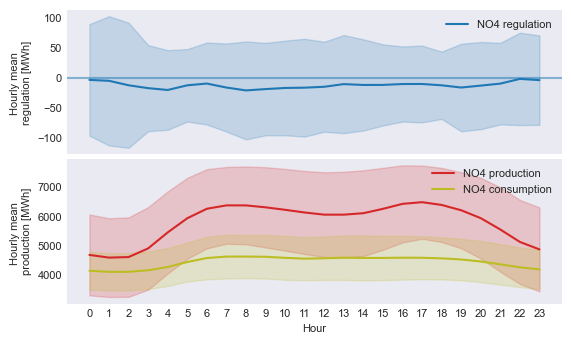

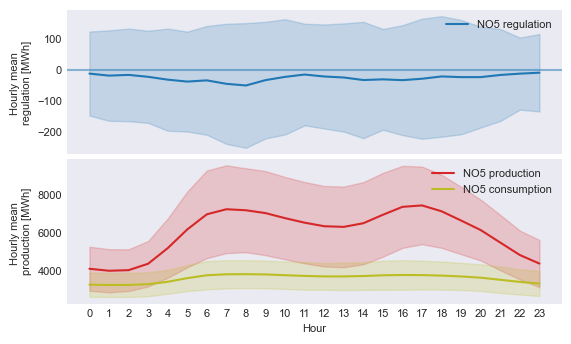

In [17]:
feature_df = df.copy()[df["year"]==2019]
#N, M = 14, 4

for i in range(1,6):
    # Hourly data for regulation volume
    reg_df = feature_df[[f"regulations_NO{i}"]]
    data_reg_df = organize_data_in_hours(reg_df)
    df_ref_stats = data_reg_df.describe()
    df_ref_mean = df_ref_stats.loc["mean"].to_numpy()
    df_ref_std = df_ref_stats.loc["std"].to_numpy()

    # Hourly data for actual volume 
    actual_df = feature_df[[f"production_NO{i}"]]
    data_actual_df = organize_data_in_hours(actual_df)
    df_actual_stats = data_actual_df.describe()
    df_actual_mean = df_actual_stats.loc["mean"].to_numpy()
    df_actual_std = df_actual_stats.loc["std"].to_numpy()

#    # Hourly data for consumption
    actual_df = feature_df[[f"consumption_NO{i}"]]
    data_cons_df = organize_data_in_hours(actual_df)
    df_cons_stats = data_cons_df.describe()
    df_cons_mean = df_cons_stats.loc["mean"].to_numpy()
    df_cons_std = df_cons_stats.loc["std"].to_numpy()


    # Plotting
    fig, ax = plt.subplots(2, figsize=(figwidth/2, 3),sharex=True)
    ax[0].plot(np.arange(df_ref_mean.shape[0]), df_ref_mean, label = f"NO{i} regulation", color=color_dic['reg'])
    ax[0].fill_between(np.arange(df_ref_mean.shape[0]), df_ref_mean-df_ref_std, df_ref_mean+df_ref_std, color=color_dic['reg'],  
                       alpha=0.2, label=None)
    ax[0].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[0].set_ylabel("Hourly mean \nregulation [MWh]", fontsize=fontsize)
    ax[0].axhline(0, alpha=0.5)
    ax[0].legend(fontsize=fontsize)

    ax[1].plot(np.arange(df_actual_mean.shape[0]), df_actual_mean, label=f"NO{i} production", color=color_dic['prod'])
    ax[1].fill_between(np.arange(df_actual_mean.shape[0]), df_actual_mean-df_actual_std, df_actual_mean+df_actual_std, color=color_dic['prod'], 
                                 alpha=0.2, label=None)
    ax[1].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[1].set_xlabel("Hour", fontsize=fontsize)
    ax[1].set_ylabel("Hourly mean \nproduction [MWh]", fontsize=fontsize)

    ax[1].plot(np.arange(df_cons_mean.shape[0]), df_cons_mean, label = f"NO{i} consumption", color=color_dic['cons'])
    ax[1].fill_between(np.arange(df_cons_mean.shape[0]), df_cons_mean-df_cons_std, df_cons_mean+df_cons_std, color=color_dic['cons'], 
                                 alpha = 0.2, label=None)
    ax[1].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[1].legend(fontsize=fontsize)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() + 
                  ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(fontsize)

    
    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
    plt.show()
    fig.savefig(f"figures/nature_of_volume/periodicity_NO{i}.png", format='png', bbox_inches='tight')

## Per month volume averages

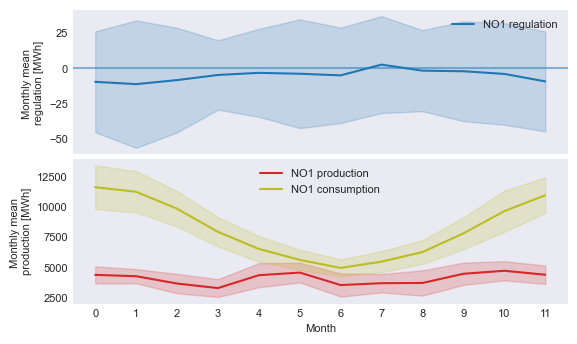

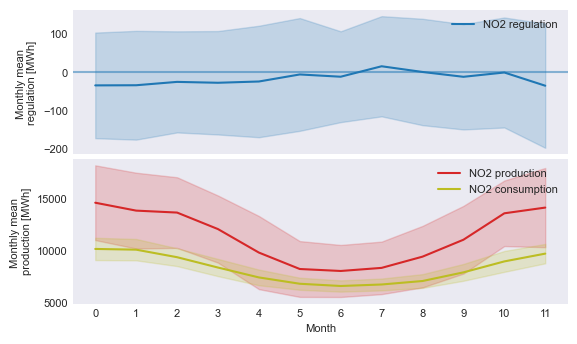

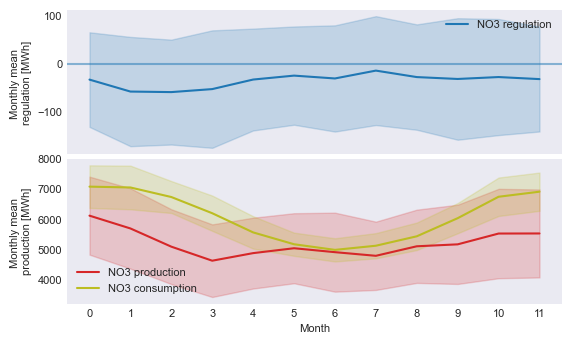

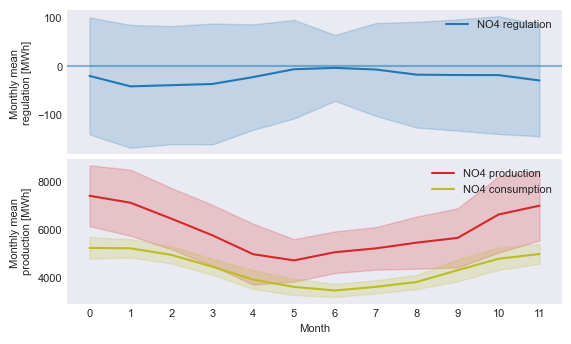

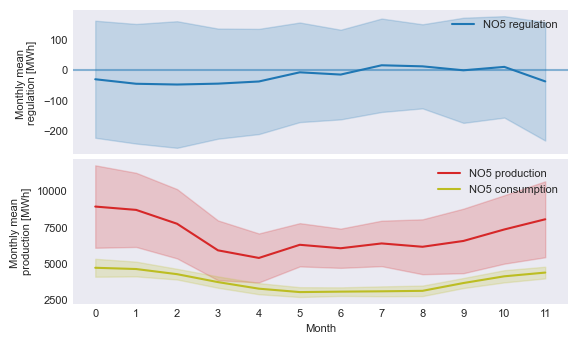

In [18]:

feature_df = df.copy()#[df["year"]==2019]
#N, M = 14, 4

for i in range(1,6):
    # Monthly data for regulation volume
    reg_df = feature_df[[f"regulations_NO{i}"]]
    data_reg_df = organize_data_in_months(reg_df)
    df_ref_stats = data_reg_df.describe()
    df_ref_mean = df_ref_stats.loc["mean"].to_numpy()
    df_ref_std = df_ref_stats.loc["std"].to_numpy()

    # Monthly data for actual volume 
    actual_df = feature_df[[f"production_NO{i}"]]
    data_actual_df = organize_data_in_months(actual_df)
    df_actual_stats = data_actual_df.describe()
    df_actual_mean = df_actual_stats.loc["mean"].to_numpy()
    df_actual_std = df_actual_stats.loc["std"].to_numpy()

    # Hourly data for consumption
    actual_df = feature_df[[f"consumption_NO{i}"]]
    data_cons_df = organize_data_in_months(actual_df)
    df_cons_stats = data_cons_df.describe()
    df_cons_mean = df_cons_stats.loc["mean"].to_numpy()
    df_cons_std = df_cons_stats.loc["std"].to_numpy()


    # Plotting
    fig, ax = plt.subplots(2, figsize=(figwidth/2, 3),sharex=True)
    ax[0].plot(np.arange(df_ref_mean.shape[0]), df_ref_mean, label = f"NO{i} regulation", color=color_dic['reg'])
    ax[0].fill_between(np.arange(df_ref_mean.shape[0]), df_ref_mean-df_ref_std, df_ref_mean+df_ref_std, color=color_dic['reg'],  
                       alpha=0.2, label=None)
    ax[0].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[0].set_ylabel("Monthly mean \nregulation [MWh]", fontsize=fontsize)
    ax[0].axhline(0, alpha=0.5)
    ax[0].legend(fontsize=fontsize)

    ax[1].plot(np.arange(df_actual_mean.shape[0]), df_actual_mean, label=f"NO{i} production", color=color_dic['prod'])
    ax[1].fill_between(np.arange(df_actual_mean.shape[0]), df_actual_mean-df_actual_std, df_actual_mean+df_actual_std, color=color_dic['prod'], 
                                 alpha=0.2, label=None)
    ax[1].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[1].set_xlabel("Month", fontsize=fontsize)
    ax[1].set_ylabel("Monthly mean \nproduction [MWh]", fontsize=fontsize)

    ax[1].plot(np.arange(df_cons_mean.shape[0]), df_cons_mean, label = f"NO{i} consumption", color=color_dic['cons'])
    ax[1].fill_between(np.arange(df_cons_mean.shape[0]), df_cons_mean-df_cons_std, df_cons_mean+df_cons_std, color=color_dic['cons'], 
                                 alpha = 0.2, label=None)
    ax[1].set_xticks(np.arange(df_ref_mean.shape[0]))
    ax[1].legend(fontsize=fontsize)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() + 
                  ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(fontsize)
    
    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
    plt.show()
    fig.savefig(f"figures/nature_of_volume/periodicity_month_NO{i}.png", format='png', bbox_inches='tight')

## Correlation matrix

C:\Users\forraust\AppData\Local\Temp\ipykernel_14780\4017227978.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xmajorticklabels(), fontsize=fontsize)


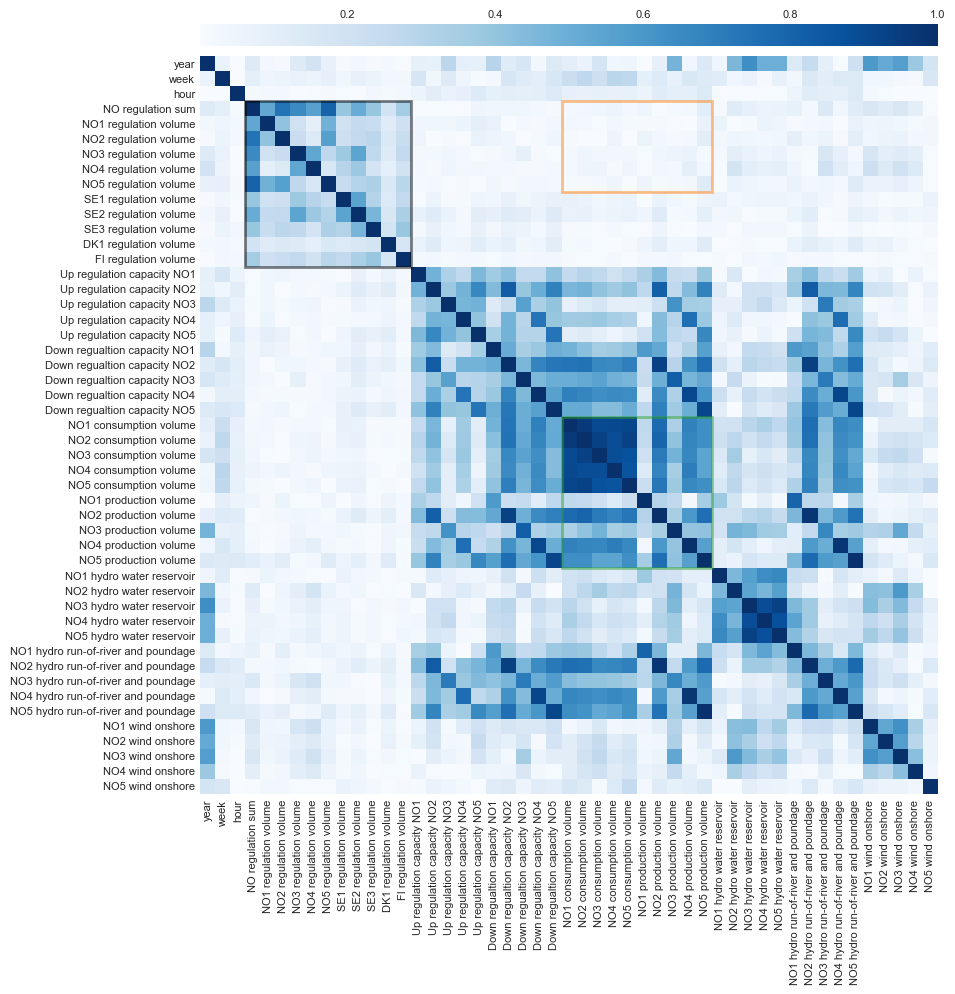

In [19]:
analysis_zones = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'SE1', 'SE2', 'SE3', 'DK1', 'FI']
all_reg_zones = ['year', 'week', 'hour'] + [f'regulations_{zone}' for zone in analysis_zones]
all_reg_zones_labels = ['year', 'week', 'hour'] + [f'{zone} regulation volume' for zone in analysis_zones]

all_prod_zones = [f'production_NO{i}' for i in range(1, 6)]
all_prod_zones_label = [f'NO{i} production volume' for i in range(1, 6)]

all_cons_zones = [f'consumption_NO{i}' for i in range(1, 6)]
all_cons_zones_label = [f'NO{i} consumption volume' for i in range(1, 6)]

NO_regup_zones = [f'capacity_regulations_up{zone}' for zone in NO_zones]
NO_regdown_zones = [f'capacity_regulations_down{zone}' for zone in NO_zones]
NO_regup_zones_label = [f'Up regulation capacity {zone}' for zone in NO_zones]
NO_regdown_zones_label = [f'Down regualtion capacity {zone}' for zone in NO_zones]


plot_cats = ['Hydro Run-of-river and poundage',
             'Hydro Water Reservoir', 
             'Wind Onshore']

plot_cats_labels = ['hydro water reservoir', 'hydro run-of-river and poundage', 'wind onshore']

prod_cols = []
prod_cols_labels = []
for j in range(len(plot_cats)):
    prod_cols = prod_cols + [f'NO{i}_prod_'+plot_cats[j] for i in range(1,6)]
    prod_cols_labels = prod_cols_labels + [f'NO{i} '+plot_cats_labels[j] for i in range(1,6)]

df_prod = production_df[prod_cols]
df_prod.columns = prod_cols_labels


# Copy dataframe and rename columns with labels
mergedDf = df[all_reg_zones + NO_regup_zones + NO_regdown_zones + all_cons_zones + all_prod_zones].copy()
mergedDf = mergedDf.merge(df_prod, left_index=True, right_index=True)
mergedDf.columns = all_reg_zones_labels + NO_regup_zones_label + NO_regdown_zones_label + all_cons_zones_label + all_prod_zones_label + prod_cols_labels

mergedDf.insert(3, 'NO regulation sum', mergedDf[['NO1 regulation volume', 'NO2 regulation volume', 'NO3 regulation volume',
                        'NO4 regulation volume', 'NO5 regulation volume']].sum(axis=1))

fig, ax = plt.subplots(figsize=(figwidth, figwidth))

corr = mergedDf.corr().abs()
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap='Blues',
            square=True, ax=ax, cbar=False)
#sns.diverging_palette(220, 10, as_cmap=True)
# add color bar above chart
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='3%', pad=0.1)
fig.add_axes(cax)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
# Change tick position to top (with the default tick position "bottom", ticks
# overlap the image).
cax.xaxis.set_ticks_position("top")
cax.set_xticklabels(cax.get_xmajorticklabels(), fontsize=fontsize)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fontsize)
from matplotlib.patches import Rectangle

ax.add_patch(Rectangle((3, 3), 11, 11, edgecolor='black', fill=False, lw=2, alpha=0.5))
ax.add_patch(Rectangle((24, 3), 10, 6, edgecolor=color_dic['other2'], fill=False, lw=2, alpha=0.5))
ax.add_patch(Rectangle((24,24), 10, 10, edgecolor=color_dic['other1'], fill=False, lw=2, alpha=0.5))

fig.savefig(f"figures/correlations/correlations_all_volumes.png", format='png', bbox_inches='tight')


# Plotting figures price

## Moving average - up-regulation

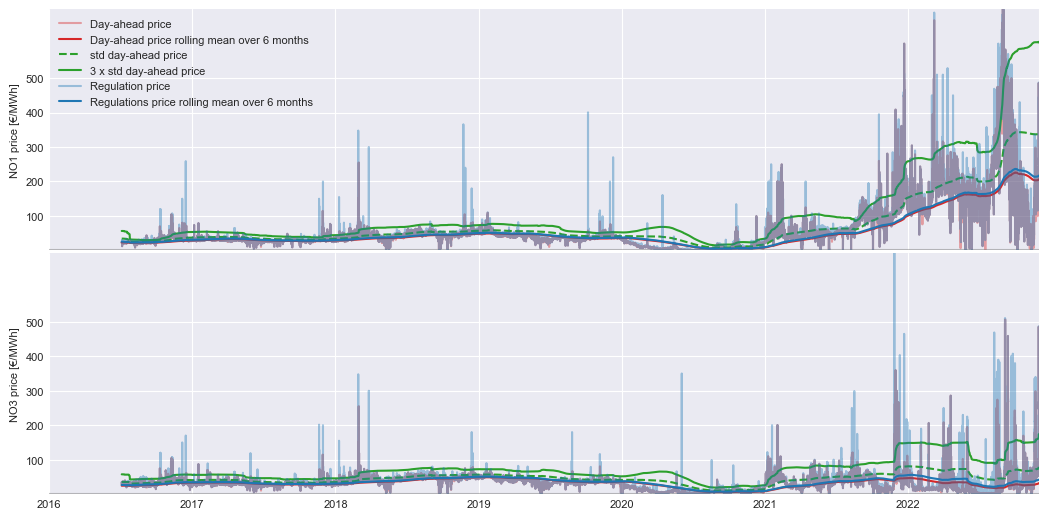

In [20]:
#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new
# Removing outliers with more than 20 sigma, rare event on Nov 26 2021
#k=20
#reg_price_df[reg_price_df > reg_price_df.std()*k] = reg_price_df.std()*k
#dayahead_price_df[dayahead_price_df > dayahead_price_df.std()*k] = dayahead_price_df.std()*k

included_zones = [1,3]
N=len(included_zones)
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
ax[0].set_ylim(0,700)

for i in range(0, N):
        NO_dayahead_price_series = dayahead_price_df[f"NO{included_zones[i]} day ahead price"]
#        NO_dayahead_price_series.loc[NO_dayahead_price_series > NO_dayahead_price_series.std()*k] = NO_dayahead_price_series.std()*k
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[i], grid='True', label='Day-ahead price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[i], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
 #       NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"].copy()
        
 #       NO_dayahead_price_series.name = ""
        windows2 = NO_dayahead_price_series.rolling(window_size)
        moving_averages2 = windows2.mean()
        std_up = windows2.std()
        moving_std_up = std_up + moving_averages2
        moving_std_up3 = std_up*3 + moving_averages2

        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="std day-ahead price", grid='True', linestyle='dashed')
        ax[i] = moving_std_up3[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="3 x std day-ahead price", grid='True')

        ax[i].set_ylabel(f"NO{included_zones[i]} price [€/MWh]", fontsize=fontsize)
        ax[i].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{included_zones[i]} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[i], grid='True', label='Regulation price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        if i==0:
            ax[i].legend(fontsize=fontsize)
            ax[i].set_yticks([100, 200, 300, 400, 500])

        ax[i].set_xlabel("")
        ax[i].set_xlim(dayahead_price_df.index.min(), dayahead_price_df.index.max())

        ax[i].tick_params(axis='x', labelrotation=0)
        for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
            label.set_fontsize(fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.01)

fig.savefig(f"figures/nature_of_price/historic_prices_up.png", bbox_inches='tight')


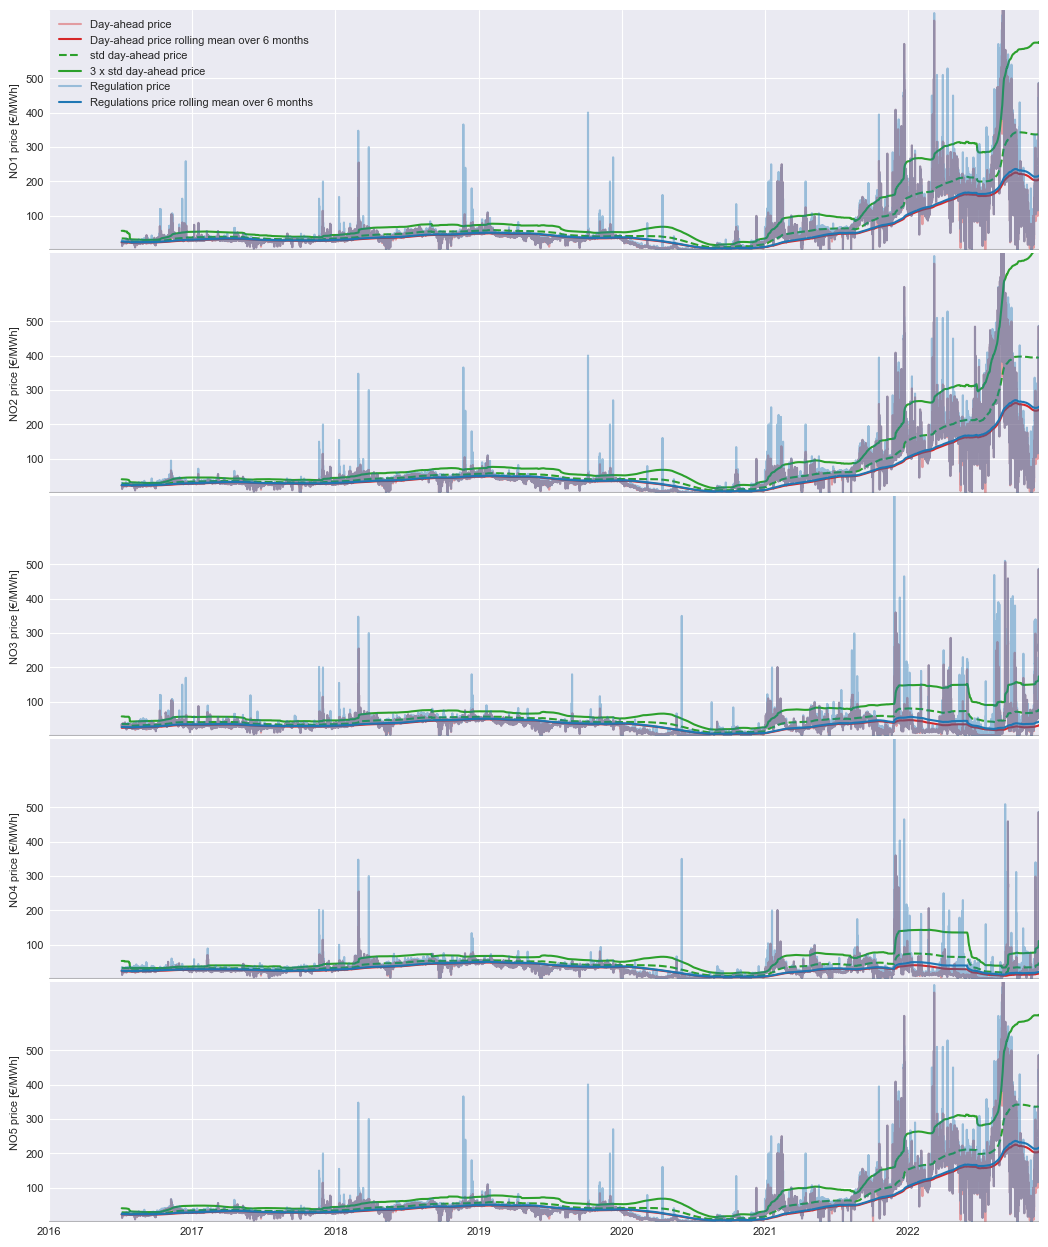

In [21]:
#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new
# Removing outliers with more than 20 sigma, rare event on Nov 26 2021
#k=20
#reg_price_df[reg_price_df > reg_price_df.std()*k] = reg_price_df.std()*k
#dayahead_price_df[dayahead_price_df > dayahead_price_df.std()*k] = dayahead_price_df.std()*k

included_zones = [1,2,3,4,5]
N=len(included_zones)
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
ax[0].set_ylim(0,700)

for i in range(0, N):
        NO_dayahead_price_series = dayahead_price_df[f"NO{included_zones[i]} day ahead price"]
#        NO_dayahead_price_series.loc[NO_dayahead_price_series > NO_dayahead_price_series.std()*k] = NO_dayahead_price_series.std()*k
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[i], grid='True', label='Day-ahead price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[i], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
 #       NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"].copy()
        
 #       NO_dayahead_price_series.name = ""
        windows2 = NO_dayahead_price_series.rolling(window_size)
        moving_averages2 = windows2.mean()
        std_up = windows2.std()
        moving_std_up = std_up + moving_averages2
        moving_std_up3 = std_up*3 + moving_averages2

        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="std day-ahead price", grid='True', linestyle='dashed')
        ax[i] = moving_std_up3[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="3 x std day-ahead price", grid='True')

        ax[i].set_ylabel(f"NO{included_zones[i]} price [€/MWh]", fontsize=fontsize)
        ax[i].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{included_zones[i]} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[i], grid='True', label='Regulation price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        if i==0:
            ax[i].legend(fontsize=fontsize)
            ax[i].set_yticks([100, 200, 300, 400, 500])

        ax[i].set_xlabel("")
        ax[i].set_xlim(dayahead_price_df.index.min(), dayahead_price_df.index.max())

        ax[i].tick_params(axis='x', labelrotation=0)
        for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
            label.set_fontsize(fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.01)

fig.savefig(f"figures/nature_of_price/historic_prices_up_all.png", bbox_inches='tight')


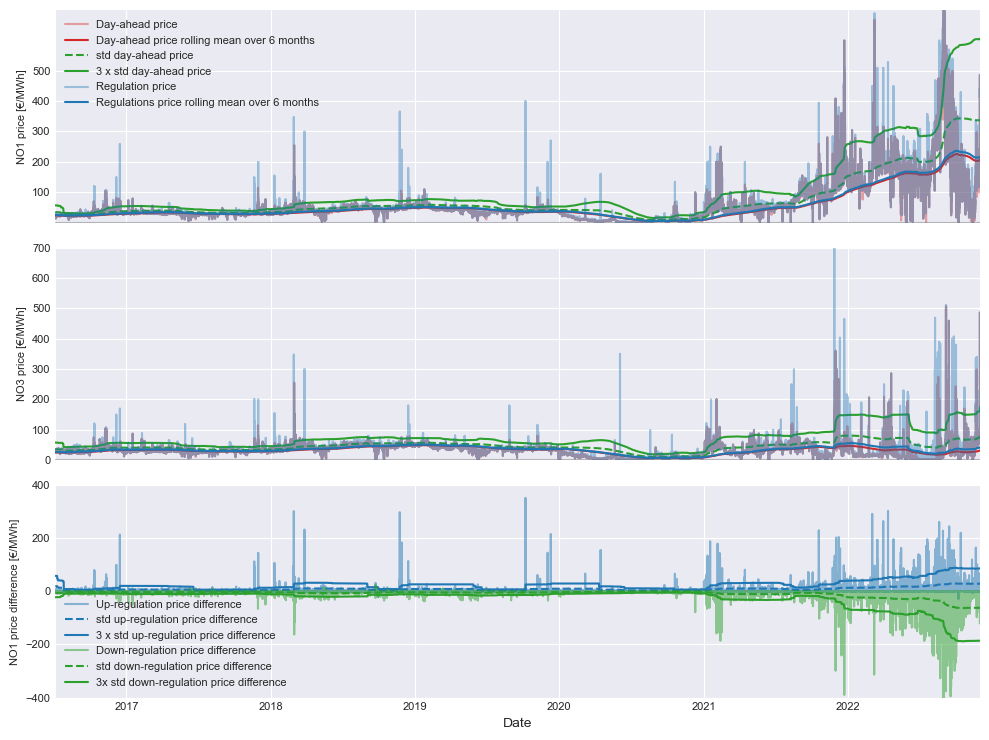

In [22]:
#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new
# Removing outliers with more than 20 sigma, rare event on Nov 26 2021
#k=20
#reg_price_df[reg_price_df > reg_price_df.std()*k] = reg_price_df.std()*k
#dayahead_price_df[dayahead_price_df > dayahead_price_df.std()*k] = dayahead_price_df.std()*k

included_zones = [1,3]
N=len(included_zones)+1
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=False)
ax[0].set_ylim(0,700)
ax[1].set_ylim(0,700)


# inclusion of other figure----------------------------------------------------------------------

# Make new cell with four panels:
# NO125 and NO34, and delta price. Clear increase in delta price - that is interesting!

#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new

#  ------------------------------------------------------------------

for i in range(0, N-1):
        NO_dayahead_price_series = dayahead_price_df[f"NO{included_zones[i]} day ahead price"]
#        NO_dayahead_price_series.loc[NO_dayahead_price_series > NO_dayahead_price_series.std()*k] = NO_dayahead_price_series.std()*k
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[i], grid='True', label='Day-ahead price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[i], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
 #       NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"].copy()
        
 #       NO_dayahead_price_series.name = ""
        windows2 = NO_dayahead_price_series.rolling(window_size)
        moving_averages2 = windows2.mean()
        std_up = windows2.std()
        moving_std_up = std_up + moving_averages2
        moving_std_up3 = std_up*3 + moving_averages2

        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="std day-ahead price", grid='True', linestyle='dashed')
        ax[i] = moving_std_up3[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="3 x std day-ahead price", grid='True')

        ax[i].set_ylabel(f"NO{included_zones[i]} price [€/MWh]", fontsize=fontsize)
        ax[i].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{included_zones[i]} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[i], grid='True', label='Regulation price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        if i==0:
            ax[i].legend(fontsize=fontsize)
            ax[i].set_yticks([100, 200, 300, 400, 500])

        ax[i].set_xlabel("")
        ax[i].set_xlim(dayahead_price_df.index.min(), dayahead_price_df.index.max())

        ax[i].tick_params(axis='x', labelrotation=0)
        for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
            label.set_fontsize(fontsize)


# ------------------- Inclusion of other figure- ---------------------------------
for i in range(0,1):
        ax[2].set_ylim(-400, 400)

        NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"]
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()


                
        windows2 = NO_dayahead_price_series.rolling(window_size)
        #moving_averages2 = windows2.mean()
        moving_std_up = moving_averages + windows2.std()
        

        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{i+1} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()



        delta_price_up = df[f'delta_prices_up_NO{i+1}'].copy()
#        ax[2] = delta_price_up[window_size:].abs().plot(ax=ax[1], color=color_dic['other1'], alpha=0.4, grid=True)
        ax[2] = delta_price_up[window_size:].plot(ax=ax[2], color=color_dic['reg'], alpha=0.5, grid=True, label='Up-regulation price difference')
        ax[2].set_ylabel(f"NO{i+1} price difference [€/MWh]", fontsize=fontsize)
        ax[2].set_xlabel("")

        windows3 = delta_price_up.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_up = windows3.std()
        moving_std_up3 = 3*moving_std_up

        

        ax[2] = moving_std_up[window_size:].plot(ax=ax[2], color=color_dic['reg'], alpha=1, grid=True, label='std up-regulation price difference', linestyle='dashed')

        ax[2] = moving_std_up3[window_size:].plot(ax=ax[2], color=color_dic['reg'], alpha=1, grid=True, label='3 x std up-regulation price difference')

        delta_price_down = df[f'delta_prices_down_NO{i+1}'].copy()
        ax[2] = delta_price_down[window_size:].plot(ax=ax[2], color=color_dic['other1'], alpha=0.5, grid=True, label='Down-regulation price difference')

        windows3 = delta_price_down.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = -windows3.std()
        moving_std_down3 = moving_std_down*3

        ax[2] = moving_std_down[window_size:].plot(ax=ax[2], color=color_dic['other1'], alpha=1, grid=True, label='std down-regulation price difference', linestyle='dashed')

        ax[2] = moving_std_down3[window_size:].plot(ax=ax[2], color=color_dic['other1'], alpha=1, grid=True, label='3x std down-regulation price difference')

        ax[2].legend(fontsize=fontsize)
        for label in (ax[2].get_yticklabels() + ax[2].get_xticklabels()):
            label.set_fontsize(fontsize)

        plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.1)
# ----------------------------------------------------------------------------------


plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.01)

fig.tight_layout()
fig.savefig(f"figures/nature_of_price/historic_prices_up_and_price_difference.png", bbox_inches='tight')


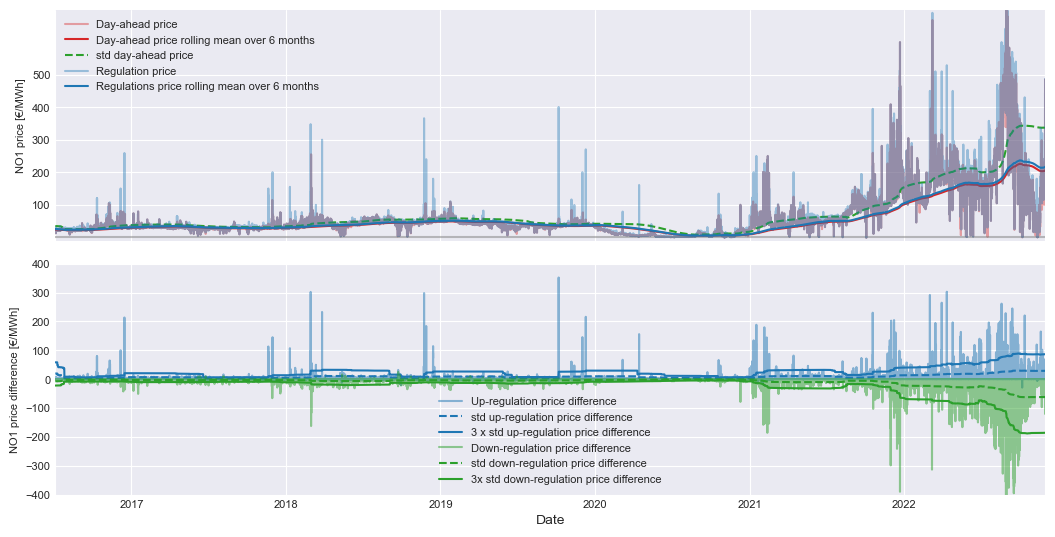

In [23]:
# Make new cell with four panels:
# NO125 and NO34, and delta price. Clear increase in delta price - that is interesting!

#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new

for i in range(0,1):
        fig, ax = plt.subplots(2, figsize=(figwidth, 2*2.5), sharex=True)
        ax[0].set_ylim(-10, 700)
        ax[1].set_ylim(-400, 400)

        NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"]
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[0] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[0], grid='True', label='Day-ahead price')

        ax[0] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[0], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
                
        windows2 = NO_dayahead_price_series.rolling(window_size)
        #moving_averages2 = windows2.mean()
        moving_std_up = moving_averages + windows2.std()
        
        ax[0] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[0], 
                                                 label="std day-ahead price", linestyle='dashed', grid='True')

        ax[0].set_xlabel("")
        ax[0].set_ylabel(f"NO{i+1} price [€/MWh]", fontsize=fontsize)
        ax[0].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{i+1} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[0] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[0], grid='True', label='Regulation price')

        ax[0] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[0], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        delta_price_up = df[f'delta_prices_up_NO{i+1}'].copy()
#        ax[1] = delta_price_up[window_size:].abs().plot(ax=ax[1], color=color_dic['other1'], alpha=0.4, grid=True)
        ax[1] = delta_price_up[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=0.5, grid=True, label='Up-regulation price difference')
        ax[1].set_ylabel(f"NO{i+1} price difference [€/MWh]", fontsize=fontsize)
        ax[1].set_xlabel("")

        windows3 = delta_price_up.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_up = windows3.std()
        moving_std_up3 = 3*moving_std_up

        

        ax[1] = moving_std_up[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=1, grid=True, label='std up-regulation price difference', linestyle='dashed')

        ax[1] = moving_std_up3[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=1, grid=True, label='3 x std up-regulation price difference')

        delta_price_down = df[f'delta_prices_down_NO{i+1}'].copy()
        ax[1] = delta_price_down[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=0.5, grid=True, label='Down-regulation price difference')

        windows3 = delta_price_down.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = -windows3.std()
        moving_std_down3 = moving_std_down*3

        ax[1] = moving_std_down[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=1, grid=True, label='std down-regulation price difference', linestyle='dashed')

        ax[1] = moving_std_down3[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=1, grid=True, label='3x std down-regulation price difference')

        ax[0].legend(fontsize=fontsize)
        ax[1].legend(fontsize=fontsize)
        ax[0].set_yticks([100, 200, 300, 400, 500])
        ax[0].tick_params(axis='x', labelrotation=90)
        for label in (ax[0].get_yticklabels() + ax[0].get_xticklabels() + ax[1].get_yticklabels() + ax[1].get_xticklabels()):
            label.set_fontsize(fontsize)

        plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.1)

        fig.savefig(f"figures/nature_of_price/historic_price_diffs_NO{i+1}.png", bbox_inches='tight')


## Moving average - down-regulation

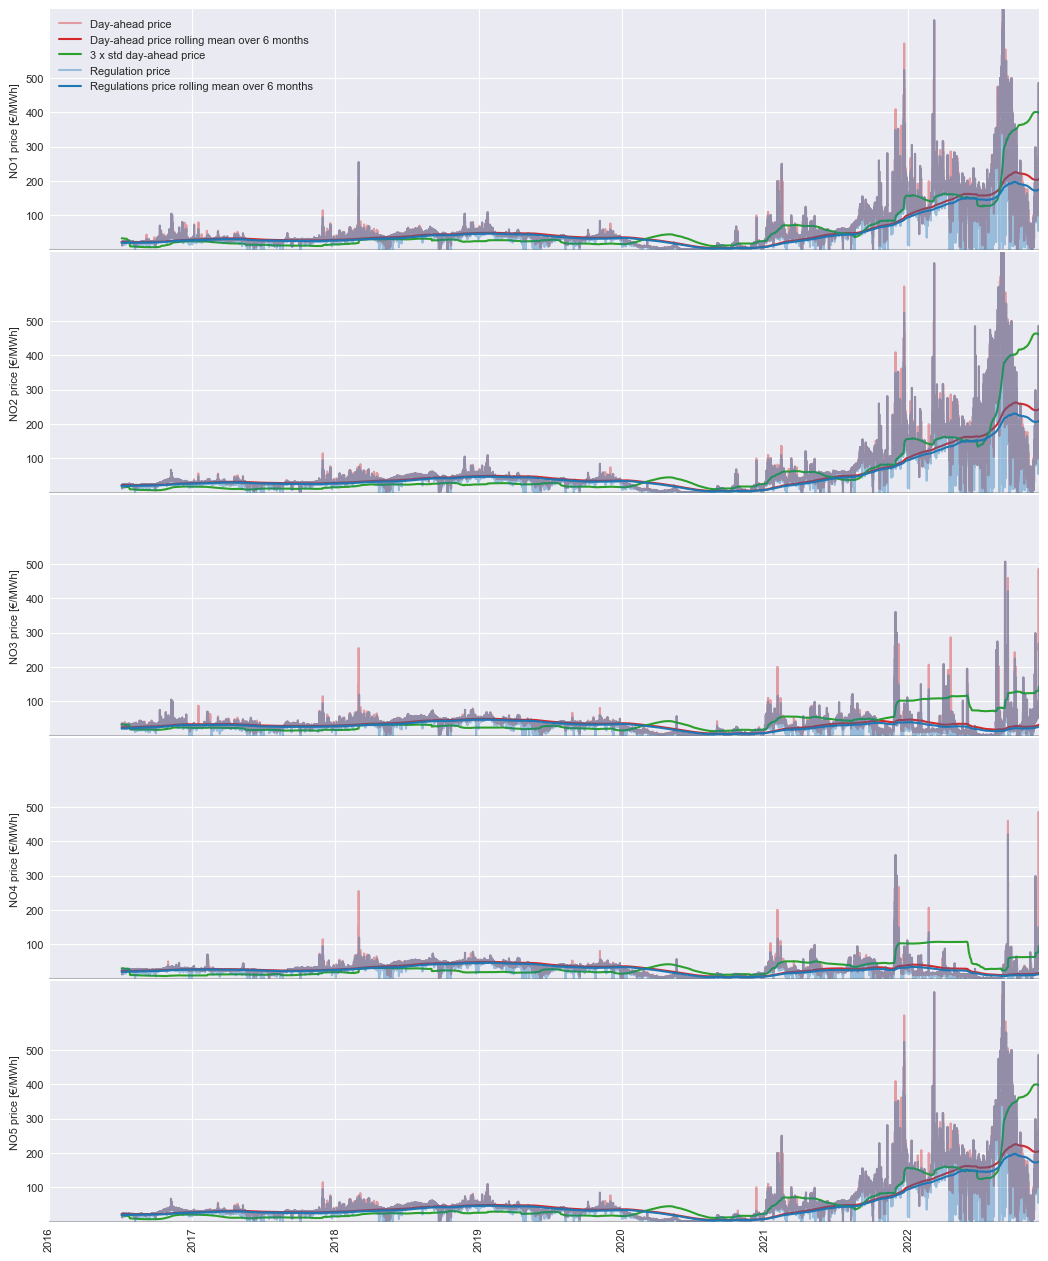

In [24]:
#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_down_NO1", "regulations_prices_down_NO2", "regulations_prices_down_NO3",
                      "regulations_prices_down_NO4", "regulations_prices_down_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new

N=5
fig, ax = plt.subplots(N, figsize=(figwidth, N*2.5), sharex=True, sharey=True)
ax[0].set_ylim(0,700)

for i in range(0, N):
        NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"]
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[i], grid='True', label='Day-ahead price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[i], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
 #       NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"].copy()
        
 #       NO_dayahead_price_series.name = ""
        windows2 = NO_dayahead_price_series.rolling(window_size)
        moving_averages2 = windows2.mean()
        moving_std_up = windows2.std()*3

        
        ax[i] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[i], 
                                                 label="3 x std day-ahead price", grid='True')

        ax[i].set_ylabel(f"NO{i+1} price [€/MWh]", fontsize=fontsize)
        ax[i].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{i+1} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[i] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[i], grid='True', label='Regulation price')

        ax[i] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[i], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        if i==0:
            ax[i].legend(fontsize=fontsize)
            ax[i].set_yticks([100, 200, 300, 400, 500])

        ax[i].set_xlabel("")
        ax[i].set_xlim(dayahead_price_df.index.min(), dayahead_price_df.index.max())

        ax[i].tick_params(axis='x', labelrotation=90)
        for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
            label.set_fontsize(fontsize)

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.01)

fig.savefig(f"figures/nature_of_price/historic_prices_down.png", bbox_inches='tight')


## Price differences

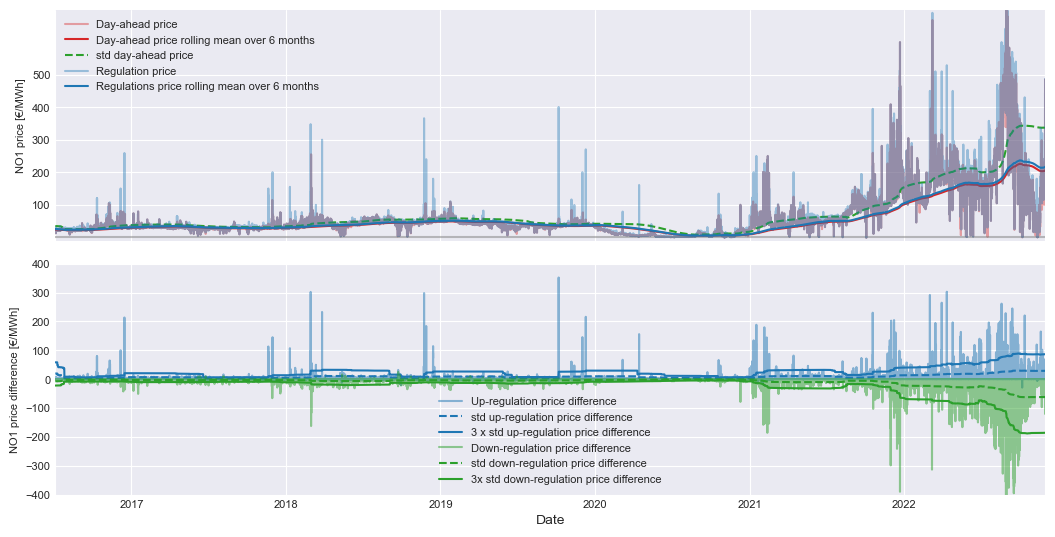

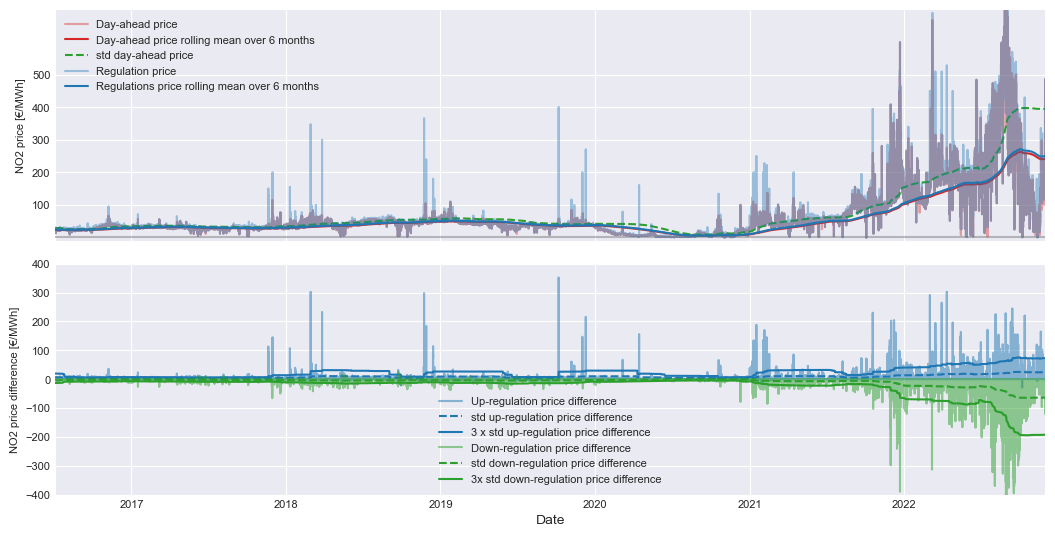

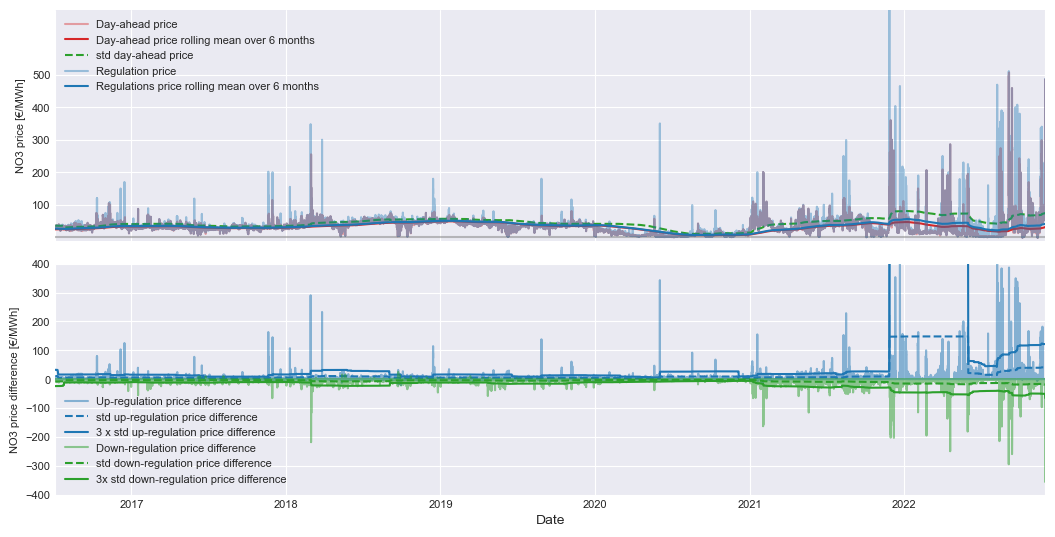

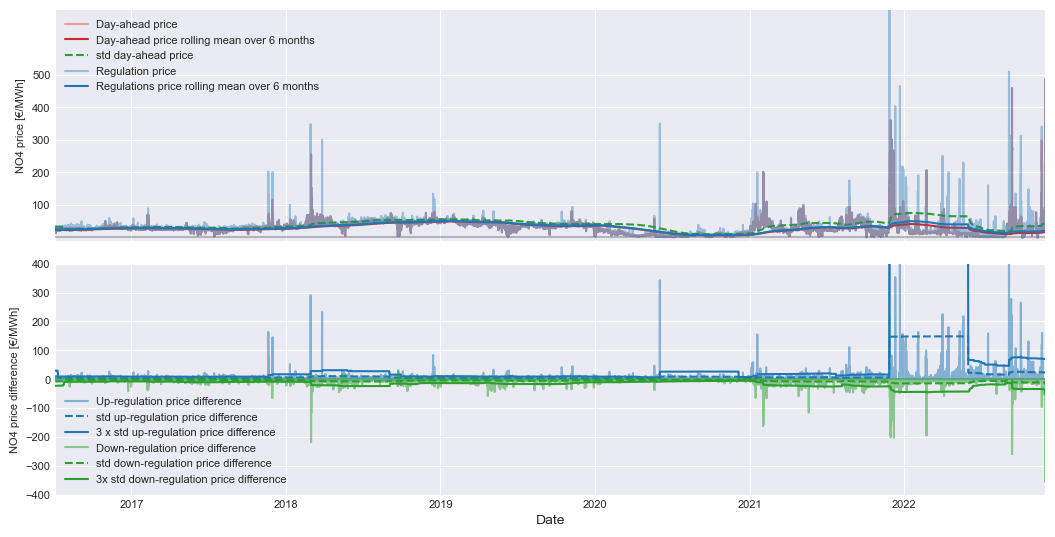

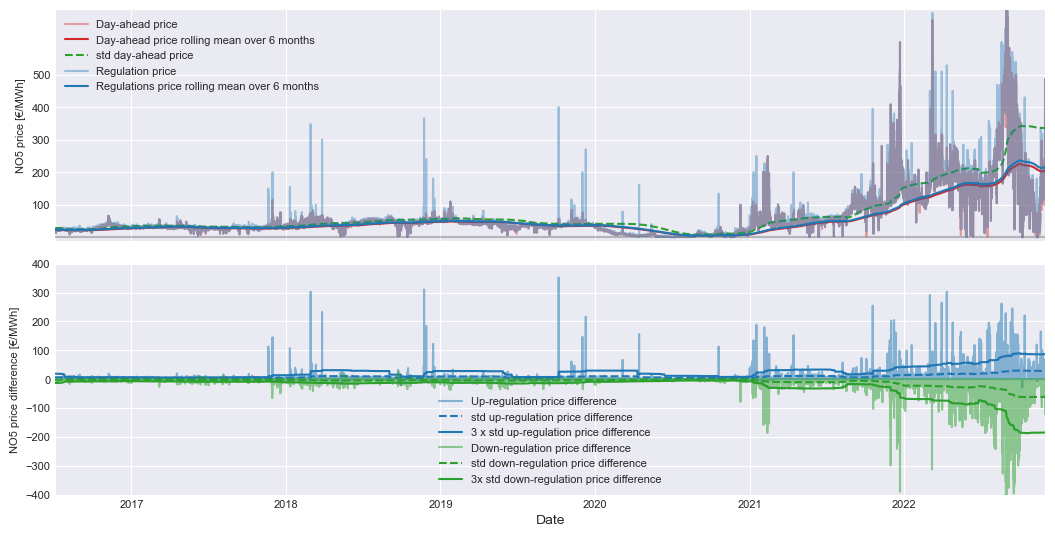

In [25]:
# Make new cell with four panels:
# NO125 and NO34, and delta price. Clear increase in delta price - that is interesting!

#plt.plot(df['NO1_da_price'])
Nmonths = 6
window_size = 24*31*Nmonths #8777

dayahead_zones_analysis = ["year", "day_ahead_prices_NO1", "day_ahead_prices_NO2", "day_ahead_prices_NO3", 
                           "day_ahead_prices_NO4", "day_ahead_prices_NO5"]
dayahead_zones_analysis_new = ["year", "NO1 day ahead price", "NO2 day ahead price", "NO3 day ahead price", 
                               "NO4 day ahead price", "NO5 day ahead price"]
dayahead_price_df = df[dayahead_zones_analysis].copy()
dayahead_price_df.columns = dayahead_zones_analysis_new

reg_zones_analysis = ["year","regulations_prices_up_NO1", "regulations_prices_up_NO2", "regulations_prices_up_NO3",
                      "regulations_prices_up_NO4", "regulations_prices_up_NO5"]
reg_zones_analysis_new = ["year", "NO1 regulation price", "NO2 regulation price", "NO3 regulation price",
                          "NO4 regulation price", "NO5 regulation price"]
reg_price_df = df[reg_zones_analysis].copy()
reg_price_df.columns = reg_zones_analysis_new

for i in range(5):
        fig, ax = plt.subplots(2, figsize=(figwidth, 2*2.5), sharex=True)
        ax[0].set_ylim(-10, 700)
        ax[1].set_ylim(-400, 400)

        NO_dayahead_price_series = dayahead_price_df[f"NO{i+1} day ahead price"]
        NO_dayahead_price_series.name = ""
        windows = NO_dayahead_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[0] = NO_dayahead_price_series[window_size:].plot(alpha=0.4, c=color_dic['prod'], 
                                                     ax=ax[0], grid='True', label='Day-ahead price')

        ax[0] = moving_averages[window_size:].plot(c=color_dic['prod'], ax=ax[0], 
                                                   label=f"Day-ahead price rolling mean over {Nmonths} months", grid='True')
                
        windows2 = NO_dayahead_price_series.rolling(window_size)
        #moving_averages2 = windows2.mean()
        moving_std_up = moving_averages + windows2.std()
        
        ax[0] = moving_std_up[window_size:].plot(c=color_dic['other1'], ax=ax[0], 
                                                 label="std day-ahead price", linestyle='dashed', grid='True')

        ax[0].set_xlabel("")
        ax[0].set_ylabel(f"NO{i+1} price [€/MWh]", fontsize=fontsize)
        ax[0].axhline(0, color=color_dic['helper'], alpha=0.5)
        
        # Regulation prices
        NO_reg_price_series = reg_price_df[f"NO{i+1} regulation price"]
        NO_reg_price_series.name = ""
        windows = NO_reg_price_series.rolling(window_size)
        moving_averages = windows.mean()

        ax[0] = NO_reg_price_series[window_size:].plot(alpha=0.4, c=color_dic['reg'], 
                                                       ax=ax[0], grid='True', label='Regulation price')

        ax[0] = moving_averages[window_size:].plot(c=color_dic['reg'], ax=ax[0], 
                                                   label=f"Regulations price rolling mean over {Nmonths} months", grid='True')

        delta_price_up = df[f'delta_prices_up_NO{i+1}'].copy()
#        ax[1] = delta_price_up[window_size:].abs().plot(ax=ax[1], color=color_dic['other1'], alpha=0.4, grid=True)
        ax[1] = delta_price_up[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=0.5, grid=True, label='Up-regulation price difference')
        ax[1].set_ylabel(f"NO{i+1} price difference [€/MWh]", fontsize=fontsize)
        ax[1].set_xlabel("")

        windows3 = delta_price_up.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_up = windows3.std()
        moving_std_up3 = 3*moving_std_up

        

        ax[1] = moving_std_up[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=1, grid=True, label='std up-regulation price difference', linestyle='dashed')

        ax[1] = moving_std_up3[window_size:].plot(ax=ax[1], color=color_dic['reg'], alpha=1, grid=True, label='3 x std up-regulation price difference')

        delta_price_down = df[f'delta_prices_down_NO{i+1}'].copy()
        ax[1] = delta_price_down[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=0.5, grid=True, label='Down-regulation price difference')

        windows3 = delta_price_down.abs().rolling(window_size)
        moving_averages3 = windows3.mean()
        moving_std_down = -windows3.std()
        moving_std_down3 = moving_std_down*3

        ax[1] = moving_std_down[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=1, grid=True, label='std down-regulation price difference', linestyle='dashed')

        ax[1] = moving_std_down3[window_size:].plot(ax=ax[1], color=color_dic['other1'], alpha=1, grid=True, label='3x std down-regulation price difference')

        ax[0].legend(fontsize=fontsize)
        ax[1].legend(fontsize=fontsize)
        ax[0].set_yticks([100, 200, 300, 400, 500])
        ax[0].tick_params(axis='x', labelrotation=90)
        for label in (ax[0].get_yticklabels() + ax[0].get_xticklabels() + ax[1].get_yticklabels() + ax[1].get_xticklabels()):
            label.set_fontsize(fontsize)

        plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.98, 
                    wspace=0.01, 
                    hspace=0.1)

        fig.savefig(f"figures/nature_of_price/historic_price_diffs_NO{i+1}.png", bbox_inches='tight')


## Normalized DFT on data

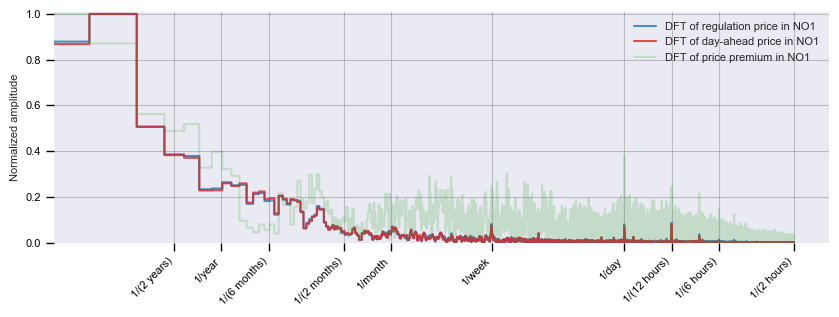

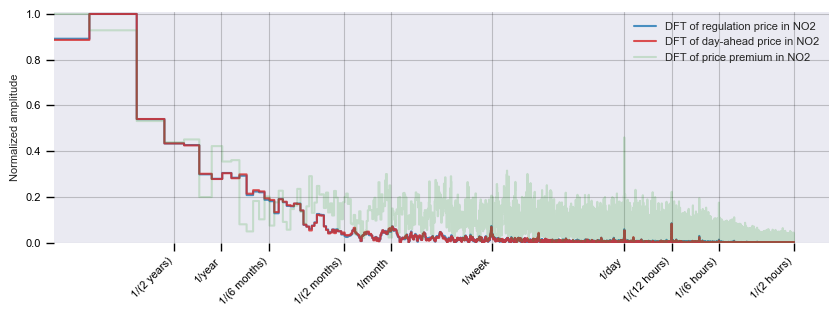

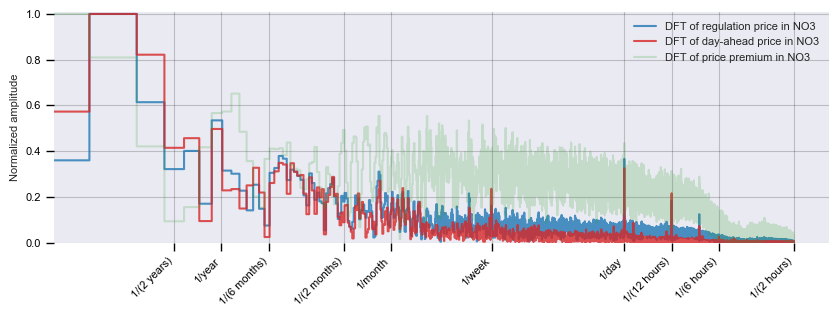

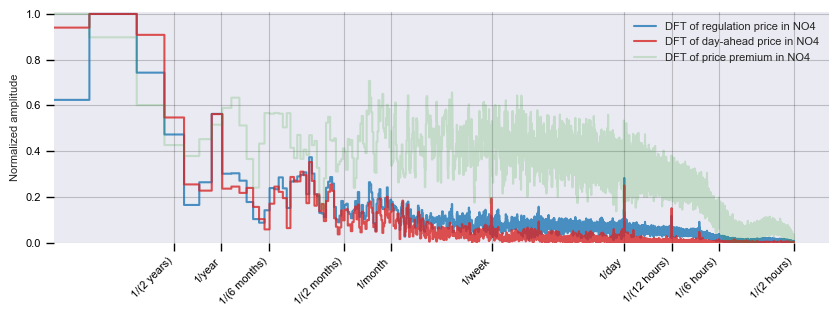

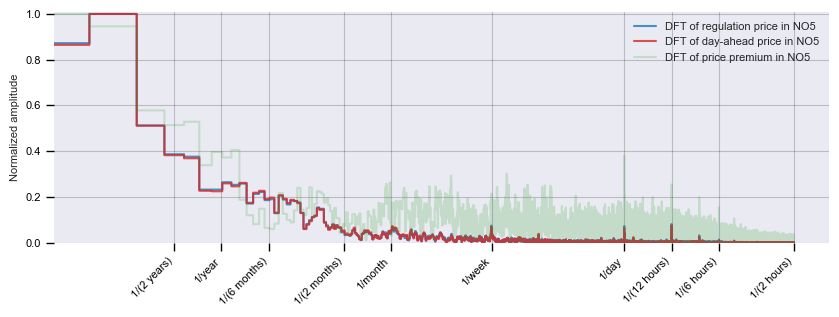

In [26]:
NO_reg_zones = [f'regulations_NO{i+1}' for i in range(5)]
NO_cons_zones = [f'consumption_NO{i+1}' for i in range(5)]
NO_prod_zones = [f'production_NO{i+1}' for i in range(5)]

reg_zones_analysis = [f'regulations_prices_up_NO{i+1}' for i in range(5)]
reg_zones_analysis_new = ["NO1 regulation price","NO2 regulation price","NO3 regulation price","NO4 regulation price","NO5 regulation price"]
delta_prices = [f'delta_prices_up_NO{i+1}' for i in range(5)]

NO_da_price = [f'day_ahead_prices_NO{i+1}' for i in range(5)]
labels = ['1/(2 years)', '1/year', '1/(6 months)', '1/(2 months)', '1/month', '1/week', '1/day', '1/(12 hours)', '1/(6 hours)', '1/(2 hours)']
ticks =  [0.5, 1, 2, 6, 12, 53, 365.2524, 2*365.2524, 4*365.2524, 12*365.2524]

zone_ind = 1
for reg_zone, reg_zone_im, da_zone_price, delta_price in zip(NO_reg_zones, reg_zones_analysis, NO_da_price, delta_prices):
    plt.figure(figsize=(figwidth, 3))
#-------------------- REGULATION PRICE ---------------------
    reg_vol_fft = df[reg_zone_im].to_numpy()

    fft = tf.signal.rfft(reg_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = reg_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, alpha=0.8 ,linestyle="-", 
            label="DFT of regulation price in NO"+str(zone_ind), c=color_dic['reg'])


    #-------------------- DAY-AHEAD PRICE ---------------------
    reg_vol_fft = df[da_zone_price].to_numpy()

    fft = tf.signal.rfft(reg_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = reg_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, alpha=0.8 ,linestyle="-", 
            label="DFT of day-ahead price in NO"+str(zone_ind), c=color_dic['prod'])

    #-------------------- DELTA PRICE ---------------------
    reg_vol_fft = df[delta_price].to_numpy()

    fft = tf.signal.rfft(reg_vol_fft)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = reg_vol_fft.shape[0]
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    res = np.array(np.abs(fft))
    res = np.sort(res)
    res = res[::-1]

    normalization_factor = np.sort(np.abs(fft))[::-1][1] # Sorted decending

    plt.step(f_per_year, np.abs(fft)/normalization_factor, alpha=0.2 ,linestyle="-", 
            label="DFT of price premium in NO"+str(zone_ind), c=color_dic['other1'])


    plt.xscale('log')
    plt.ylim(0, 1.01)
    plt.xticks(ticks, labels=labels, rotation = 45,ha="right" ,fontsize=fontsize)
    plt.tick_params(direction='out', length=6, width=1, colors='black',
               grid_color='black', grid_alpha=0.2)
    plt.grid()
    _ = plt.ylabel('Normalized amplitude', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.legend(fontsize=fontsize)
 
    plt.savefig(f"figures/nature_of_price/DFT_price_NO{zone_ind}.png",  bbox_inches='tight')
    zone_ind=zone_ind+1

## Patterns price

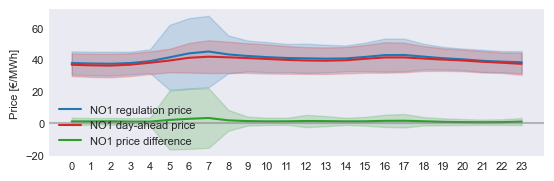

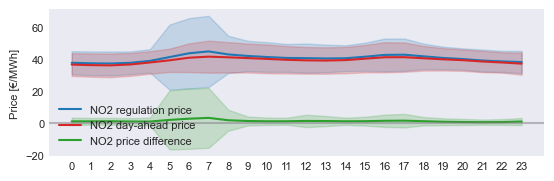

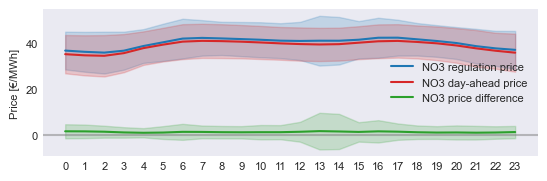

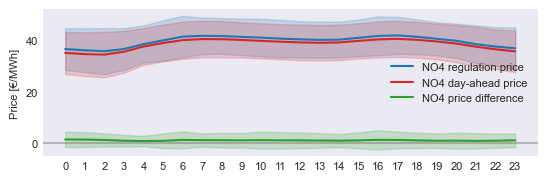

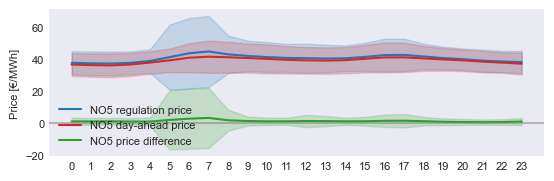

In [27]:
feature_df = df.copy()[df["year"]==2019]
#N, M = 14, 4

for i in range(1,6):
    # Hourly data for regulation price
    reg_df = feature_df[[f"regulations_prices_up_NO{i}"]]
    data_reg_df = organize_data_in_hours(reg_df)
    df_ref_stats = data_reg_df.describe()
    df_ref_mean = df_ref_stats.loc["mean"].to_numpy()
    df_ref_std = df_ref_stats.loc["std"].to_numpy()

    # Hourly data for da price
    actual_df = feature_df[[f"day_ahead_prices_NO{i}"]]
    data_actual_df = organize_data_in_hours(actual_df)
    df_actual_stats = data_actual_df.describe()
    df_actual_mean = df_actual_stats.loc["mean"].to_numpy()
    df_actual_std = df_actual_stats.loc["std"].to_numpy()

    # Hourly data for da price delta
    delta_df = feature_df[[f"delta_prices_up_NO{i}"]]
    data_delta_df = organize_data_in_hours(delta_df)
    df_delta_stats = data_delta_df.describe()
    df_delta_mean = df_delta_stats.loc["mean"].to_numpy()
    df_delta_std = df_delta_stats.loc["std"].to_numpy()


    # Plotting
    fig, ax = plt.subplots(1, figsize=(figwidth/2, 1.5),sharex=True)
    ax.plot(np.arange(df_ref_mean.shape[0]), df_ref_mean, label=f"NO{i} regulation price", 
                      color=color_dic['reg'])
    ax.fill_between(np.arange(df_ref_mean.shape[0]), df_ref_mean-df_ref_std, df_ref_mean+df_ref_std, 
                              color=color_dic['reg'], alpha=0.2, label=None)


    ax.plot(np.arange(df_actual_mean.shape[0]), df_actual_mean, label=f"NO{i} day-ahead price", color=color_dic['prod'])
    ax.fill_between(np.arange(df_actual_mean.shape[0]), df_actual_mean-df_actual_std, df_actual_mean+df_actual_std, color=color_dic['prod'], 
                                 alpha=0.2, label=None)

    ax.plot(np.arange(df_delta_mean.shape[0]), df_delta_mean, label=f"NO{i} price difference", color=color_dic['other1'])
    ax.fill_between(np.arange(df_delta_mean.shape[0]), df_delta_mean-df_delta_std, df_delta_mean+df_delta_std, color=color_dic['other1'], 
                                 alpha=0.2, label=None)

    ax.axhline(0, color=color_dic['helper'], alpha=0.5)

    ax.set_xticks(np.arange(df_ref_mean.shape[0]))
    ax.set_ylabel("Price [€/MWh]", fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)

    
    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
    plt.show()
    fig.savefig(f"figures/nature_of_price/periodicity_NO{i}.png", format='png', bbox_inches='tight')

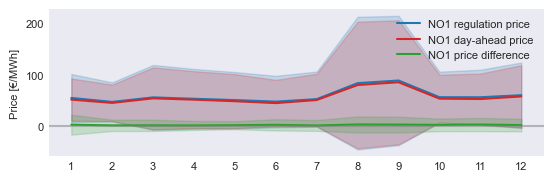

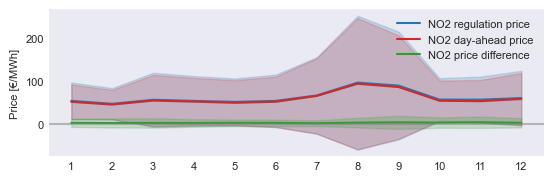

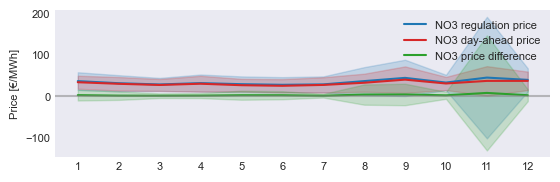

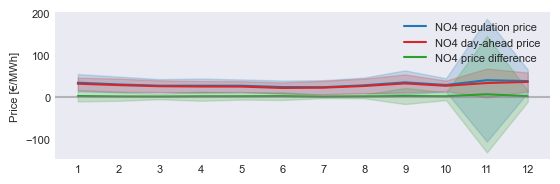

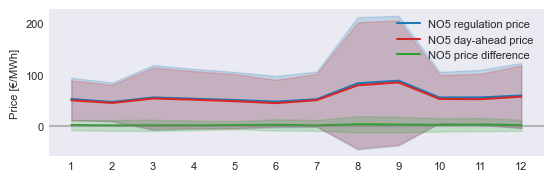

In [28]:
feature_df = df.copy()#[df["year"]==2019]
#N, M = 14, 4

for i in range(1,6):
    # Hourly data for regulation price
    reg_df = feature_df[[f"regulations_prices_up_NO{i}"]]
    data_reg_df = organize_data_in_months(reg_df)
    df_ref_stats = data_reg_df.describe()
    df_ref_mean = df_ref_stats.loc["mean"].to_numpy()
    df_ref_std = df_ref_stats.loc["std"].to_numpy()

    # Hourly data for da price
    actual_df = feature_df[[f"day_ahead_prices_NO{i}"]]
    data_actual_df = organize_data_in_months(actual_df)
    df_actual_stats = data_actual_df.describe()
    df_actual_mean = df_actual_stats.loc["mean"].to_numpy()
    df_actual_std = df_actual_stats.loc["std"].to_numpy()

   # Hourly data for da price delta
    delta_df = feature_df[[f"delta_prices_up_NO{i}"]]
    data_delta_df = organize_data_in_months(delta_df)
    df_delta_stats = data_delta_df.describe()
    df_delta_mean = df_delta_stats.loc["mean"].to_numpy()
    df_delta_std = df_delta_stats.loc["std"].to_numpy()


    # Plotting
    fig, ax = plt.subplots(1, figsize=(figwidth/2, 1.5),sharex=True)
    ax.plot(np.arange(df_ref_mean.shape[0]), df_ref_mean, label=f"NO{i} regulation price", 
                      color=color_dic['reg'])
    ax.fill_between(np.arange(df_ref_mean.shape[0]), df_ref_mean-df_ref_std, df_ref_mean+df_ref_std, 
                              color=color_dic['reg'], alpha=0.2, label=None)

    ax.plot(np.arange(df_actual_mean.shape[0]), df_actual_mean, label=f"NO{i} day-ahead price", color=color_dic['prod'])
    ax.fill_between(np.arange(df_actual_mean.shape[0]), df_actual_mean-df_actual_std, df_actual_mean+df_actual_std, color=color_dic['prod'], 
                                 alpha=0.2, label=None)

    ax.plot(np.arange(df_delta_mean.shape[0]), df_delta_mean, label=f"NO{i} price difference", color=color_dic['other1'])
    ax.fill_between(np.arange(df_delta_mean.shape[0]), df_delta_mean-df_delta_std, df_delta_mean+df_delta_std, color=color_dic['other1'], 
                                 alpha=0.2, label=None)

    ax.axhline(0, color=color_dic['helper'], alpha=0.5)




    ax.set_xticks(np.arange(df_ref_mean.shape[0]), labels=np.arange(1, 1+ df_ref_mean.shape[0]))

    ax.set_ylabel("Price [€/MWh]", fontsize=fontsize)
    ax.legend(fontsize=fontsize)


    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)

    
    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
    plt.show()
    fig.savefig(f"figures/nature_of_price/periodicity_months_NO{i}.png", format='png', bbox_inches='tight')

## Autocorrelation price difference

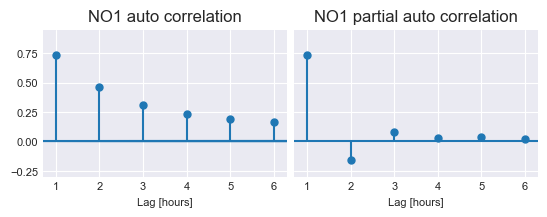

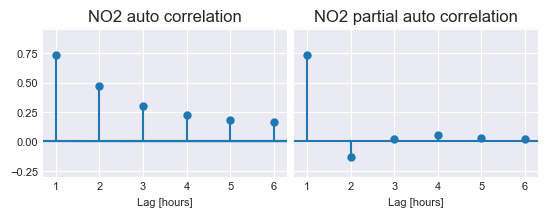

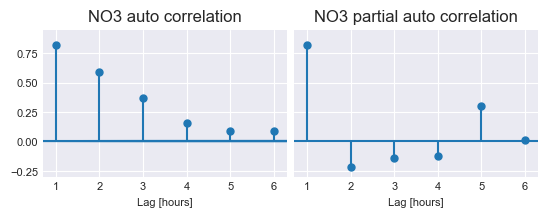

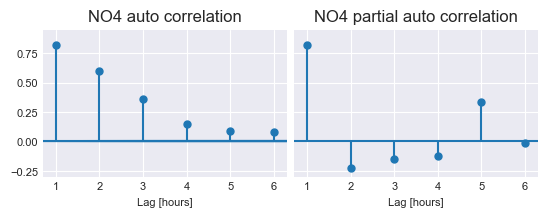

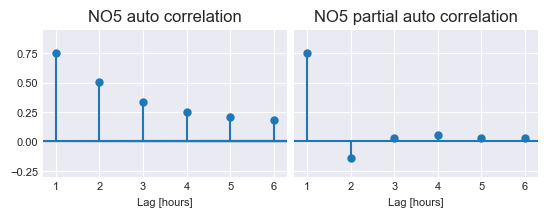

In [29]:
nbf_lags = 6
N, M = figwidth/2, 1.5

for i in range(1,6):
    reg_vol = df[f"delta_prices_up_NO{i}"].to_numpy()
    fig, ax = plt.subplots(ncols=2, figsize=(N, M), sharey=True)
    
    for k in [0,1]:
        ax[k].set_xlabel('Lag [hours]', fontsize=fontsize)
        ax[k].set_xticks(np.arange(nbf_lags+1))
        ax[k].set_xlim(0.7, nbf_lags+0.3)
        ax[k].grid()

    acfax = plot_acf(reg_vol, lags=nbf_lags, fft=False, ax=ax[0])
    pacfax = plot_pacf(reg_vol, lags=nbf_lags, ax=ax[1])

    ax[0].set_ylim(-0.3, 0.95)
    ax[0].set_title(f"NO{i} auto correlation")
    ax[1].set_title(f"NO{i} partial auto correlation")
    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() + 
                  ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(fontsize)

    plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)


    fig.savefig(f"figures/autocorrelations/acf_deltaprice_auto_corr_NO{i}.png", bbox_inches="tight")
    plt.show()

## Correlations price

C:\Users\forraust\AppData\Local\Temp\ipykernel_14780\3354682056.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xmajorticklabels(), fontsize=fontsize)


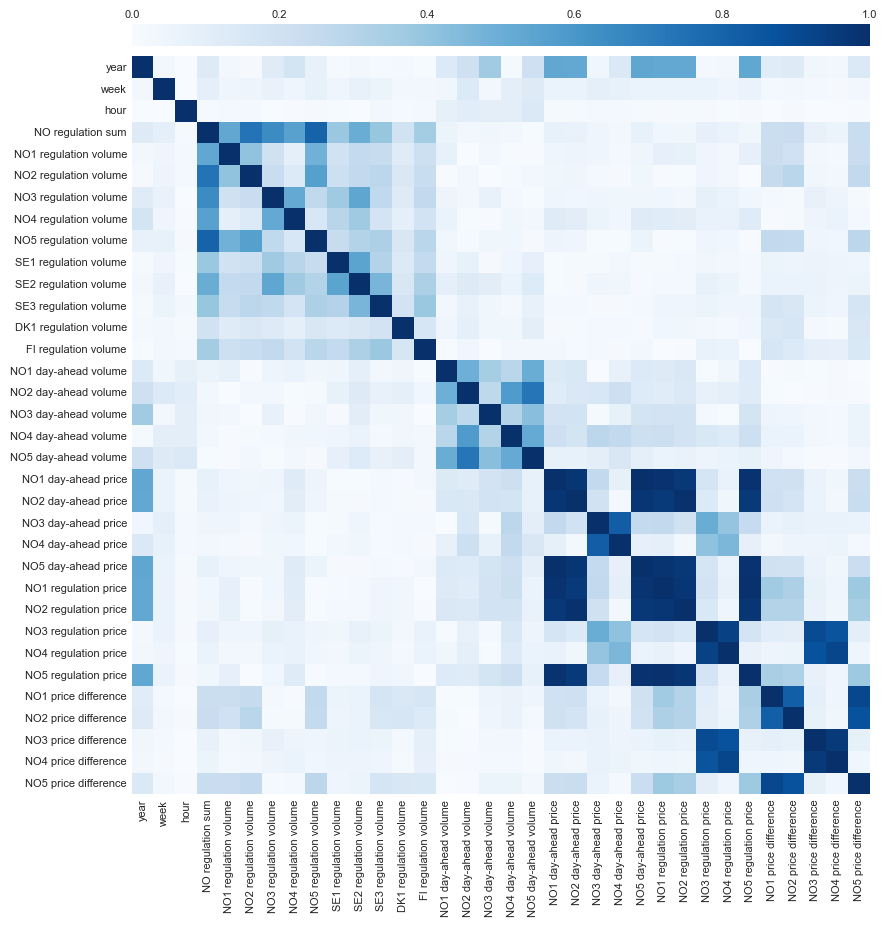

In [30]:
analysis_zones = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'SE1', 'SE2', 'SE3', 'DK1', 'FI']
all_reg_zones = ['year', 'week', 'hour'] + [f'regulations_{zone}' for zone in analysis_zones]
all_reg_zones_labels = ['year', 'week', 'hour'] + [f'{zone} regulation volume' for zone in analysis_zones]

all_prod_zones = [f'production_NO{i}' for i in range(1, 6)]
all_prod_zones_label = [f'NO{i} production volume' for i in range(1, 6)]

all_cons_zones = [f'consumption_NO{i}' for i in range(1, 6)]
all_cons_zones_label = [f'NO{i} consumption volume' for i in range(1, 6)]

all_da_volume = [f'day_ahead_sell_NO{i}' for i in range(1, 6)]
all_da_volume_labels = [f'NO{x} day-ahead volume' for x in range(1,6)]

#HERE
all_da_price = [f'day_ahead_prices_NO{i}' for i in range(1, 6)]
all_da_price_labels = [f'NO{x} day-ahead price' for x in range(1,6)]

all_im_price = [f'regulations_prices_up_NO{i}' for i in range(1, 6)]
all_im_price_labels = [f'NO{x} regulation price' for x in range(1,6)]

all_delta_price = [f'delta_prices_up_NO{i}' for i in range(1, 6)]
all_delta_price_labels = [f'NO{x} price difference' for x in range(1,6)]


Nz = 5
#N = len(plot_cats) + 1

mergedDf = df[all_reg_zones + all_da_volume + all_da_price + all_im_price + all_delta_price].copy()
mergedDf.columns = all_reg_zones_labels + all_da_volume_labels + all_da_price_labels + all_im_price_labels + all_delta_price_labels
mergedDf.insert(3, 'NO regulation sum', mergedDf[['NO1 regulation volume', 'NO2 regulation volume', 'NO3 regulation volume',
                        'NO4 regulation volume', 'NO5 regulation volume']].sum(axis=1))


fig, ax = plt.subplots(figsize=(figwidth, figwidth))

#order = [f'NO{x} hydro water reservoir' for x in range(1,6)] + [f'NO{x} hydro run-of-river and poundage' for x in range(1,6)] + [f'NO{x} wind onshore' for x in range(1,6)] + ['NO1 regulation volume', 'NO2 regulation volume', 'NO3 regulation volume', 'NO4 regulation volume', 'NO5 regulation volume']


corr = mergedDf.corr().abs()
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap='Blues',
            square=True, ax=ax, cbar=False)

# add color bar above chart
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='3%', pad=0.1)
fig.add_axes(cax)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")
# Change tick position to top (with the default tick position "bottom", ticks
# overlap the image).
cax.xaxis.set_ticks_position("top")
cax.set_xticklabels(cax.get_xmajorticklabels(), fontsize=fontsize)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fontsize)

#ax.add_patch(Rectangle((3, 3), 10, 10, edgecolor=color_dic['other1'], fill=False, lw=2, alpha=0.5))
#ax.add_patch(Rectangle((13, 3), 10, 5, edgecolor=color_dic['other2'], fill=False, lw=2, alpha=0.5))
#ax.add_patch(Rectangle((13, 13), 10, 10, edgecolor='black', fill=False, lw=2, alpha=0.5))

fig.savefig(f"figures/correlations/correlations_prices.png", format='png', bbox_inches='tight')


## Histogram day-ahead price

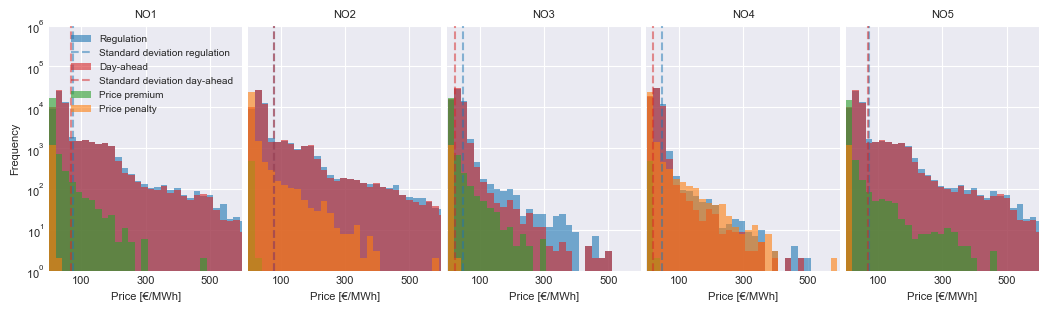

In [31]:
im_volumes_NO = df.loc[:, "regulations_NO1":"regulations_NO5"]

im_prices_NO = df.loc[:, "regulations_prices_up_NO1":"regulations_prices_up_NO5"]

delta_prices_NO = df.loc[:, "delta_prices_up_NO1":"delta_prices_up_NO5"]

da_prices_NO = df.loc[:, "day_ahead_prices_NO1":"day_ahead_prices_NO5" ]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(figwidth, 2.5), sharey=True, sharex=True)

Nmax = 1000
Nbins = 50
bins = np.linspace(0, Nmax, Nbins)
ax[0].set_xlim(-1, 600)
ax[0].set_ylim(1, 1e6)

ax[0].set_yscale('log')

for i in range(5):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(fontsize)

    ax[i].grid(axis='x')
    ax[i].set_title(f'NO{i+1}', fontsize=fontsize)   
    ax[i].set_xlabel(f'Price [€/MWh]', fontsize=fontsize)


    # REG-PRICE
    data_val = im_prices_NO.iloc[:,i].copy()
    data_upper = data_val[data_val > 0].copy()
    ax[i] = data_upper.hist(bins=bins, ax=ax[i], alpha=0.6, label='Regulation', color=color_dic['reg'])
    std_upper = data_upper.std(axis=0)
    ax[i].axvline(std_upper, linestyle="--", color=color_dic['reg'], alpha=0.5, label="Standard deviation regulation")


    # DAY-AHEAD PRICE
    data_val = da_prices_NO.iloc[:,i].copy()
    data_upper = data_val[data_val > 0].copy()
    ax[i] = data_upper.hist(bins=bins, ax=ax[i], alpha=0.6, label='Day-ahead', color=color_dic['prod'])
    std_upper = data_upper.std(axis=0)
    ax[i].axvline(std_upper, linestyle="--", color=color_dic['prod'], alpha=0.5, label="Standard deviation day-ahead")

    # DELTA PRICE
    # FROM David-Andreas THESIS: DELTA PRICE = REG_PRICE-DA_PRICE
    data_val = delta_prices_NO.iloc[:,i].copy()
    data_upper = data_val[data_val > 0].copy()
    data_lower = np.abs(data_val[data_val < 0].copy())
    ax[i] = data_upper.hist(bins=bins, ax=ax[i], alpha=0.6, label='Price premium', color=color_dic['other1'])
    std_upper = data_upper.std(axis=0)
    #ax[i].axvline(std_upper, linestyle="--", color=color_dic['other1'], alpha=0.2, label="Standard deviation day-ahead")
    ax[i] = data_lower.hist(bins=bins, ax=ax[i], alpha=0.6, label='Price penalty', color=color_dic['other2'])

    if i == 0:
        ax[0].legend(loc="upper right", fontsize=0.9*fontsize)
        ax[0].set_ylabel('Frequency', fontsize=fontsize)

    ax[i].set_xticks([100, 300, 500])

plt.subplots_adjust(left=0.00,
                    right=0.99, 
                    bottom=0.01, 
                    top=0.99, 
                    wspace=0.03, 
                    hspace=0.03)
#fig.tight_layout()
fig.savefig(f"figures/nature_of_price/target_price_histogram.png",  bbox_inches='tight')

## Statistics

### Statistics

In [32]:

for key in ['regulations', 'delta_prices_up', 'delta_prices_down']:
    index = [f'{key}_NO{i+1}' for i in range(5)]
    im_volumes_desc = df[index]
    count_zero = (im_volumes_desc == 0).sum()/im_volumes_desc.shape[0]
    median = im_volumes_desc.median(axis=0)
    im_volumes_desc  = im_volumes_desc.describe().T
    im_volumes_desc["zero fraction"] = count_zero
    im_volumes_desc["median"] = median

    im_volumes_desc = im_volumes_desc.round(decimals=2)
    im_volumes_desc = im_volumes_desc.drop("count", axis=1)
    display(im_volumes_desc)
    im_volumes_desc.to_csv(f"figures/statistics/{key}_stats.csv")
    

mean     std     min   25%  50%   75%     max  \
regulations_NO1  -5.03   35.18  -334.0   0.0  0.0  0.00   424.0   
regulations_NO2 -16.09  140.61 -1447.2 -27.6  0.0  0.00  1400.0   
regulations_NO3 -34.85  112.88 -1335.0 -59.0  0.0  0.00   680.7   
regulations_NO4 -21.48  112.66 -1466.8 -10.0  0.0  0.00   789.0   
regulations_NO5 -19.54  175.68 -1472.3 -54.0  0.0  6.22  1205.2   

                 zero fraction  median  
regulations_NO1           0.69     0.0  
regulations_NO2           0.47     0.0  
regulations_NO3           0.44     0.0  
regulations_NO4           0.59     0.0  
regulations_NO5           0.41     0.0

mean    std    min  25%  50%   75%      max  \
delta_prices_up_NO1  2.62  12.70 -29.42  0.0  0.0  1.55   589.79   
delta_prices_up_NO2  2.31  10.63 -29.42  0.0  0.0  1.48   351.93   
delta_prices_up_NO3  2.81  42.25 -21.14  0.0  0.0  0.76  4875.19   
delta_prices_up_NO4  2.29  41.18 -21.14  0.0  0.0  0.00  4875.19   
delta_prices_up_NO5  2.55  11.73 -29.42  0.0  0.0  1.62   351.93   

                     zero fraction  median  
delta_prices_up_NO1           0.68     0.0  
delta_prices_up_NO2           0.68     0.0  
delta_prices_up_NO3           0.71     0.0  
delta_prices_up_NO4           0.74     0.0  
delta_prices_up_NO5           0.68     0.0

mean    std     min   25%  50%  75%    max  \
delta_prices_down_NO1 -5.45  20.82 -640.39 -4.42  0.0  0.0  24.91   
delta_prices_down_NO2 -5.60  21.43 -640.39 -4.37  0.0  0.0  24.91   
delta_prices_down_NO3 -3.61   9.54 -356.28 -4.69  0.0  0.0  24.91   
delta_prices_down_NO4 -2.94   8.19 -356.28 -3.99  0.0  0.0  24.91   
delta_prices_down_NO5 -5.33  20.60 -640.39 -4.33  0.0  0.0  24.91   

                       zero fraction  median  
delta_prices_down_NO1           0.55     0.0  
delta_prices_down_NO2           0.55     0.0  
delta_prices_down_NO3           0.52     0.0  
delta_prices_down_NO4           0.56     0.0  
delta_prices_down_NO5           0.56     0.0

In [33]:
median = im_volumes_desc.median(axis=1)
median

delta_prices_down_NO1    0.0
delta_prices_down_NO2    0.0
delta_prices_down_NO3    0.0
delta_prices_down_NO4    0.0
delta_prices_down_NO5    0.0
dtype: float64

### Stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller
pd.set_option("display.precision", 8)

def hypothesis_test(df:pd.DataFrame, data_range, significance_level, key_prefix)->None:
    
    hypothesis_test_results = pd.DataFrame(columns=[f"zone", "year1", "year2", "p_value", 'AD fuller'])

    for i in range(1,6):
        data_df = df[f"{key_prefix}NO{i}"].copy()
        data_df = data_df[df["year"] >= data_range[0]]
        test_result = adfuller(data_df, regression='ctt')
        p_value = np.round(test_result[1], decimals=7)
        print(data_range[0], i, '{0:.7f}'.format(p_value), test_result[0])
    
 #       if p_value < significance_level: 
 #           print(f"{p_value = } < {significance_level}, The data is theoretically and statistically stationary")
 #           "Forkaster H0 med p<0.05 med 95% significans nivå. Forkaster hypotesen om at dataen er stasjonær"
 #           is_data_stationary = "Yes"
                
        hypothesis_test_results.loc[i, :] = [f"NO{i}", data_range[0], data_range[1], p_value, test_result[0]]

    return hypothesis_test_results

In [35]:
data_ranges = reversed([[2016, 2022], [2017, 2022], [2018, 2022], [2019, 2022], [2020, 2022], [2021, 2022], [2022, 2022]])
significance_level = 0.01
key_prefix = "day_ahead_prices_" #"delta_prices_up_"  #"regulations_"

reg_zones_analysis = ["year"] + [f'{key_prefix}NO{i+1}' for i in range(5)]
#reg_vol_df = df.iloc[0:10000][reg_zones_analysis].copy()
reg_vol_df = df[reg_zones_analysis].copy()
hypothesis_test_results = pd.DataFrame()
for data_range in data_ranges:
    hypothesis_test_results_i = hypothesis_test(reg_vol_df, data_range, significance_level, key_prefix=key_prefix)
    hypothesis_test_results = pd.concat([hypothesis_test_results, hypothesis_test_results_i])
    display(hypothesis_test_results_i)
    hypothesis_test_results.to_csv(f"figures/statistics/{key_prefix}adfuller.csv", index=False, float_format='%.7f')
display(hypothesis_test_results)

2022 1 0.0666609 -3.721462204875575
2022 2 0.0294347 -4.023670917662214
2022 3 0.0001034 -5.546853679692864
2022 4 0.0000000 -7.643189709062853
2022 5 0.0677135 -3.7152327491911907


zone year1 year2    p_value   AD fuller
1  NO1  2022  2022  0.0666609  -3.7214622
2  NO2  2022  2022  0.0294347 -4.02367092
3  NO3  2022  2022  0.0001034 -5.54685368
4  NO4  2022  2022        0.0 -7.64318971
5  NO5  2022  2022  0.0677135 -3.71523275

2021 1 0.0008451 -5.048920100238583
2021 2 0.0010358 -4.99766733798224
2021 3 0.0000504 -5.706339344327466
2021 4 0.0002024 -5.393055887440393
2021 5 0.0008595 -5.044705942932234


zone year1 year2    p_value   AD fuller
1  NO1  2021  2022  0.0008451  -5.0489201
2  NO2  2021  2022  0.0010358 -4.99766734
3  NO3  2021  2022  0.0000504 -5.70633934
4  NO4  2021  2022  0.0002024 -5.39305589
5  NO5  2021  2022  0.0008595 -5.04470594

2020 1 0.0000041 -6.233508505664998
2020 2 0.0000045 -6.216759482194052
2020 3 0.0000000 -7.105249017284266
2020 4 0.0000001 -6.942013473169174
2020 5 0.0000041 -6.233641014055425


zone year1 year2    p_value   AD fuller
1  NO1  2020  2022  0.0000041 -6.23350851
2  NO2  2020  2022  0.0000045 -6.21675948
3  NO3  2020  2022        0.0 -7.10524902
4  NO4  2020  2022  0.0000001 -6.94201347
5  NO5  2020  2022  0.0000041 -6.23364101

2019 1 0.0000000 -7.388096344394337
2019 2 0.0000000 -7.2974047703283285
2019 3 0.0000000 -8.192043564628325
2019 4 0.0000000 -7.43765652487316
2019 5 0.0000000 -7.373264855637955


zone year1 year2 p_value   AD fuller
1  NO1  2019  2022     0.0 -7.38809634
2  NO2  2019  2022     0.0 -7.29740477
3  NO3  2019  2022     0.0 -8.19204356
4  NO4  2019  2022     0.0 -7.43765652
5  NO5  2019  2022     0.0 -7.37326486

2018 1 0.0000000 -7.892075175442624
2018 2 0.0000000 -7.6118324736499225
2018 3 0.0000000 -9.063299695111446
2018 4 0.0000000 -8.152780520384114
2018 5 0.0000000 -7.848529876153733


zone year1 year2 p_value   AD fuller
1  NO1  2018  2022     0.0 -7.89207518
2  NO2  2018  2022     0.0 -7.61183247
3  NO3  2018  2022     0.0  -9.0632997
4  NO4  2018  2022     0.0 -8.15278052
5  NO5  2018  2022     0.0 -7.84852988

2017 1 0.0000000 -7.297734826057887
2017 2 0.0000001 -7.009594209998746
2017 3 0.0000000 -8.922146754468152
2017 4 0.0000000 -7.79574432942743
2017 5 0.0000000 -7.255231188375098


zone year1 year2    p_value   AD fuller
1  NO1  2017  2022        0.0 -7.29773483
2  NO2  2017  2022  0.0000001 -7.00959421
3  NO3  2017  2022        0.0 -8.92214675
4  NO4  2017  2022        0.0 -7.79574433
5  NO5  2017  2022        0.0 -7.25523119

2016 1 0.0000000 -7.152596247729063
2016 2 0.0000001 -6.925754100575088
2016 3 0.0000000 -9.264275433496454
2016 4 0.0000000 -8.505691015388987
2016 5 0.0000000 -7.135251624029977


zone year1 year2    p_value   AD fuller
1  NO1  2016  2022        0.0 -7.15259625
2  NO2  2016  2022  0.0000001  -6.9257541
3  NO3  2016  2022        0.0 -9.26427543
4  NO4  2016  2022        0.0 -8.50569102
5  NO5  2016  2022        0.0 -7.13525162

zone year1 year2    p_value   AD fuller
1  NO1  2022  2022  0.0666609  -3.7214622
2  NO2  2022  2022  0.0294347 -4.02367092
3  NO3  2022  2022  0.0001034 -5.54685368
4  NO4  2022  2022        0.0 -7.64318971
5  NO5  2022  2022  0.0677135 -3.71523275
1  NO1  2021  2022  0.0008451  -5.0489201
2  NO2  2021  2022  0.0010358 -4.99766734
3  NO3  2021  2022  0.0000504 -5.70633934
4  NO4  2021  2022  0.0002024 -5.39305589
5  NO5  2021  2022  0.0008595 -5.04470594
1  NO1  2020  2022  0.0000041 -6.23350851
2  NO2  2020  2022  0.0000045 -6.21675948
3  NO3  2020  2022        0.0 -7.10524902
4  NO4  2020  2022  0.0000001 -6.94201347
5  NO5  2020  2022  0.0000041 -6.23364101
1  NO1  2019  2022        0.0 -7.38809634
2  NO2  2019  2022        0.0 -7.29740477
3  NO3  2019  2022        0.0 -8.19204356
4  NO4  2019  2022        0.0 -7.43765652
5  NO5  2019  2022        0.0 -7.37326486
1  NO1  2018  2022        0.0 -7.89207518
2  NO2  2018  2022        0.0 -7.61183247
3  NO3  2018  2022        0.0  -9.0632997
4  NO4  2018  2022        0.0 -8.15278052
5  NO5  2018  2022        0.0 -7.84852988
1  NO1  2017  2022        0.0 -7.29773483
2  NO2  2017  2022  0.0000001 -7.00959421
3  NO3  2017  2022        0.0 -8.92214675
4  NO4  2017  2022        0.0 -7.79574433
5  NO5  2017  2022        0.0 -7.25523119
1  NO1  2016  2022        0.0 -7.15259625
2  NO2  2016  2022  0.0000001  -6.9257541
3  NO3  2016  2022        0.0 -9.26427543
4  NO4  2016  2022        0.0 -8.50569102
5  NO5  2016  2022        0.0 -7.13525162

In [36]:
data_ranges = reversed([[2016, 2022], [2017, 2022], [2018, 2022], [2019, 2022], [2020, 2022], [2021, 2022], [2022, 2022]])
significance_level = 0.01
key_prefix = "delta_prices_up_"  #"regulations_"

reg_zones_analysis = ["year"] + [f'{key_prefix}NO{i+1}' for i in range(5)]
#reg_vol_df = df.iloc[0:10000][reg_zones_analysis].copy()
reg_vol_df = df[reg_zones_analysis].copy()
hypothesis_test_results = pd.DataFrame()
for data_range in data_ranges:
    hypothesis_test_results_i = hypothesis_test(reg_vol_df, data_range, significance_level, key_prefix=key_prefix)
    hypothesis_test_results = pd.concat([hypothesis_test_results, hypothesis_test_results_i])
    display(hypothesis_test_results_i)
    hypothesis_test_results.to_csv(f"figures/statistics/{key_prefix}adfuller.csv", index=False, float_format='%.7f')
display(hypothesis_test_results)

2022 1 0.0000000 -13.237952658380545
2022 2 0.0000000 -13.037682238813925
2022 3 0.0000000 -10.357168327036378
2022 4 0.0000000 -14.297992858316674
2022 5 0.0000000 -13.214118483542213


zone year1 year2 p_value    AD fuller
1  NO1  2022  2022     0.0 -13.23795266
2  NO2  2022  2022     0.0 -13.03768224
3  NO3  2022  2022     0.0 -10.35716833
4  NO4  2022  2022     0.0 -14.29799286
5  NO5  2022  2022     0.0 -13.21411848

2021 1 0.0000000 -19.858080527204685
2021 2 0.0000000 -19.832324519679325
2021 3 0.0000000 -21.687765098706677
2021 4 0.0000000 -21.467194549051726
2021 5 0.0000000 -18.803154711947695


zone year1 year2 p_value    AD fuller
1  NO1  2021  2022     0.0 -19.85808053
2  NO2  2021  2022     0.0 -19.83232452
3  NO3  2021  2022     0.0  -21.6877651
4  NO4  2021  2022     0.0 -21.46719455
5  NO5  2021  2022     0.0 -18.80315471

2020 1 0.0000000 -23.223898311641612
2020 2 0.0000000 -24.387008444529947
2020 3 0.0000000 -25.613841690592036
2020 4 0.0000000 -26.4716843972469
2020 5 0.0000000 -23.160183734241308


zone year1 year2 p_value    AD fuller
1  NO1  2020  2022     0.0 -23.22389831
2  NO2  2020  2022     0.0 -24.38700844
3  NO3  2020  2022     0.0 -25.61384169
4  NO4  2020  2022     0.0  -26.4716844
5  NO5  2020  2022     0.0 -23.16018373

2019 1 0.0000000 -26.980489286651853
2019 2 0.0000000 -28.62750602241699
2019 3 0.0000000 -29.688093403923055
2019 4 0.0000000 -30.672025964276767
2019 5 0.0000000 -26.91330296105945


zone year1 year2 p_value    AD fuller
1  NO1  2019  2022     0.0 -26.98048929
2  NO2  2019  2022     0.0 -28.62750602
3  NO3  2019  2022     0.0  -29.6880934
4  NO4  2019  2022     0.0 -30.67202596
5  NO5  2019  2022     0.0 -26.91330296

2018 1 0.0000000 -30.467709488514846
2018 2 0.0000000 -32.55386386473789
2018 3 0.0000000 -33.26896932074567
2018 4 0.0000000 -34.38168906618241
2018 5 0.0000000 -30.39947686807776


zone year1 year2 p_value    AD fuller
1  NO1  2018  2022     0.0 -30.46770949
2  NO2  2018  2022     0.0 -32.55386386
3  NO3  2018  2022     0.0 -33.26896932
4  NO4  2018  2022     0.0 -34.38168907
5  NO5  2018  2022     0.0 -30.39947687

2017 1 0.0000000 -33.088813505863165
2017 2 0.0000000 -35.422988465887784
2017 3 0.0000000 -36.47763119701846
2017 4 0.0000000 -37.71485625506349
2017 5 0.0000000 -33.017161330908074


zone year1 year2 p_value    AD fuller
1  NO1  2017  2022     0.0 -33.08881351
2  NO2  2017  2022     0.0 -35.42298847
3  NO3  2017  2022     0.0  -36.4776312
4  NO4  2017  2022     0.0 -37.71485626
5  NO5  2017  2022     0.0 -33.01716133

2016 1 0.0000000 -27.402033791699978
2016 2 0.0000000 -29.642135553303554
2016 3 0.0000000 -39.34412962294865
2016 4 0.0000000 -40.6750616346693
2016 5 0.0000000 -27.735262157236843


zone year1 year2 p_value    AD fuller
1  NO1  2016  2022     0.0 -27.40203379
2  NO2  2016  2022     0.0 -29.64213555
3  NO3  2016  2022     0.0 -39.34412962
4  NO4  2016  2022     0.0 -40.67506163
5  NO5  2016  2022     0.0 -27.73526216

zone year1 year2 p_value    AD fuller
1  NO1  2022  2022     0.0 -13.23795266
2  NO2  2022  2022     0.0 -13.03768224
3  NO3  2022  2022     0.0 -10.35716833
4  NO4  2022  2022     0.0 -14.29799286
5  NO5  2022  2022     0.0 -13.21411848
1  NO1  2021  2022     0.0 -19.85808053
2  NO2  2021  2022     0.0 -19.83232452
3  NO3  2021  2022     0.0  -21.6877651
4  NO4  2021  2022     0.0 -21.46719455
5  NO5  2021  2022     0.0 -18.80315471
1  NO1  2020  2022     0.0 -23.22389831
2  NO2  2020  2022     0.0 -24.38700844
3  NO3  2020  2022     0.0 -25.61384169
4  NO4  2020  2022     0.0  -26.4716844
5  NO5  2020  2022     0.0 -23.16018373
1  NO1  2019  2022     0.0 -26.98048929
2  NO2  2019  2022     0.0 -28.62750602
3  NO3  2019  2022     0.0  -29.6880934
4  NO4  2019  2022     0.0 -30.67202596
5  NO5  2019  2022     0.0 -26.91330296
1  NO1  2018  2022     0.0 -30.46770949
2  NO2  2018  2022     0.0 -32.55386386
3  NO3  2018  2022     0.0 -33.26896932
4  NO4  2018  2022     0.0 -34.38168907
5  NO5  2018  2022     0.0 -30.39947687
1  NO1  2017  2022     0.0 -33.08881351
2  NO2  2017  2022     0.0 -35.42298847
3  NO3  2017  2022     0.0  -36.4776312
4  NO4  2017  2022     0.0 -37.71485626
5  NO5  2017  2022     0.0 -33.01716133
1  NO1  2016  2022     0.0 -27.40203379
2  NO2  2016  2022     0.0 -29.64213555
3  NO3  2016  2022     0.0 -39.34412962
4  NO4  2016  2022     0.0 -40.67506163
5  NO5  2016  2022     0.0 -27.73526216

In [37]:
data_ranges = reversed([[2016, 2022], [2017, 2022], [2018, 2022], [2019, 2022], [2020, 2022], [2021, 2022], [2022, 2022]])
significance_level = 0.01
key_prefix = "delta_prices_down_"  #"regulations_"

reg_zones_analysis = ["year"] + [f'{key_prefix}NO{i+1}' for i in range(5)]
#reg_vol_df = df.iloc[0:10000][reg_zones_analysis].copy()
reg_vol_df = df[reg_zones_analysis].copy()
hypothesis_test_results = pd.DataFrame()
for data_range in data_ranges:
    hypothesis_test_results_i = hypothesis_test(reg_vol_df, data_range, significance_level, key_prefix=key_prefix)
    hypothesis_test_results = pd.concat([hypothesis_test_results, hypothesis_test_results_i])
    display(hypothesis_test_results_i)
    hypothesis_test_results.to_csv(f"figures/statistics/{key_prefix}adfuller.csv", index=False, float_format='%.7f')
display(hypothesis_test_results)

2022 1 0.0000000 -8.717524016653867
2022 2 0.0000000 -8.950053108361718
2022 3 0.0000000 -9.012858692970216
2022 4 0.0000000 -8.774158170936074
2022 5 0.0000000 -8.706951018616534


zone year1 year2 p_value   AD fuller
1  NO1  2022  2022     0.0 -8.71752402
2  NO2  2022  2022     0.0 -8.95005311
3  NO3  2022  2022     0.0 -9.01285869
4  NO4  2022  2022     0.0 -8.77415817
5  NO5  2022  2022     0.0 -8.70695102

2021 1 0.0000000 -12.385461614730351
2021 2 0.0000000 -11.815727937561538
2021 3 0.0000000 -12.621828959111697
2021 4 0.0000000 -12.115075516055203
2021 5 0.0000000 -12.32070394364911


zone year1 year2 p_value    AD fuller
1  NO1  2021  2022     0.0 -12.38546161
2  NO2  2021  2022     0.0 -11.81572794
3  NO3  2021  2022     0.0 -12.62182896
4  NO4  2021  2022     0.0 -12.11507552
5  NO5  2021  2022     0.0 -12.32070394

2020 1 0.0000000 -13.918195280196553
2020 2 0.0000000 -13.78047369950757
2020 3 0.0000000 -15.292147184789442
2020 4 0.0000000 -14.101439652459383
2020 5 0.0000000 -14.252528286564154


zone year1 year2 p_value    AD fuller
1  NO1  2020  2022     0.0 -13.91819528
2  NO2  2020  2022     0.0  -13.7804737
3  NO3  2020  2022     0.0 -15.29214718
4  NO4  2020  2022     0.0 -14.10143965
5  NO5  2020  2022     0.0 -14.25252829

2019 1 0.0000000 -17.108258507698277
2019 2 0.0000000 -16.159803953720257
2019 3 0.0000000 -17.01608021933173
2019 4 0.0000000 -16.422772876912575
2019 5 0.0000000 -17.03378461930165


zone year1 year2 p_value    AD fuller
1  NO1  2019  2022     0.0 -17.10825851
2  NO2  2019  2022     0.0 -16.15980395
3  NO3  2019  2022     0.0 -17.01608022
4  NO4  2019  2022     0.0 -16.42277288
5  NO5  2019  2022     0.0 -17.03378462

2018 1 0.0000000 -18.427517402913857
2018 2 0.0000000 -17.264433078942208
2018 3 0.0000000 -18.84389883439192
2018 4 0.0000000 -18.86615912168316
2018 5 0.0000000 -18.224645190084207


zone year1 year2 p_value    AD fuller
1  NO1  2018  2022     0.0  -18.4275174
2  NO2  2018  2022     0.0 -17.26443308
3  NO3  2018  2022     0.0 -18.84389883
4  NO4  2018  2022     0.0 -18.86615912
5  NO5  2018  2022     0.0 -18.22464519

2017 1 0.0000000 -19.647387231536307
2017 2 0.0000000 -17.886497707251767
2017 3 0.0000000 -20.69616142011819
2017 4 0.0000000 -19.47430179873349
2017 5 0.0000000 -19.53324203951238


zone year1 year2 p_value    AD fuller
1  NO1  2017  2022     0.0 -19.64738723
2  NO2  2017  2022     0.0 -17.88649771
3  NO3  2017  2022     0.0 -20.69616142
4  NO4  2017  2022     0.0  -19.4743018
5  NO5  2017  2022     0.0 -19.53324204

2016 1 0.0000000 -20.100439202252918
2016 2 0.0000000 -18.08027311321147
2016 3 0.0000000 -21.56297375908759
2016 4 0.0000000 -20.199886527502272
2016 5 0.0000000 -19.946638065797263


zone year1 year2 p_value    AD fuller
1  NO1  2016  2022     0.0  -20.1004392
2  NO2  2016  2022     0.0 -18.08027311
3  NO3  2016  2022     0.0 -21.56297376
4  NO4  2016  2022     0.0 -20.19988653
5  NO5  2016  2022     0.0 -19.94663807

zone year1 year2 p_value    AD fuller
1  NO1  2022  2022     0.0  -8.71752402
2  NO2  2022  2022     0.0  -8.95005311
3  NO3  2022  2022     0.0  -9.01285869
4  NO4  2022  2022     0.0  -8.77415817
5  NO5  2022  2022     0.0  -8.70695102
1  NO1  2021  2022     0.0 -12.38546161
2  NO2  2021  2022     0.0 -11.81572794
3  NO3  2021  2022     0.0 -12.62182896
4  NO4  2021  2022     0.0 -12.11507552
5  NO5  2021  2022     0.0 -12.32070394
1  NO1  2020  2022     0.0 -13.91819528
2  NO2  2020  2022     0.0  -13.7804737
3  NO3  2020  2022     0.0 -15.29214718
4  NO4  2020  2022     0.0 -14.10143965
5  NO5  2020  2022     0.0 -14.25252829
1  NO1  2019  2022     0.0 -17.10825851
2  NO2  2019  2022     0.0 -16.15980395
3  NO3  2019  2022     0.0 -17.01608022
4  NO4  2019  2022     0.0 -16.42277288
5  NO5  2019  2022     0.0 -17.03378462
1  NO1  2018  2022     0.0  -18.4275174
2  NO2  2018  2022     0.0 -17.26443308
3  NO3  2018  2022     0.0 -18.84389883
4  NO4  2018  2022     0.0 -18.86615912
5  NO5  2018  2022     0.0 -18.22464519
1  NO1  2017  2022     0.0 -19.64738723
2  NO2  2017  2022     0.0 -17.88649771
3  NO3  2017  2022     0.0 -20.69616142
4  NO4  2017  2022     0.0  -19.4743018
5  NO5  2017  2022     0.0 -19.53324204
1  NO1  2016  2022     0.0  -20.1004392
2  NO2  2016  2022     0.0 -18.08027311
3  NO3  2016  2022     0.0 -21.56297376
4  NO4  2016  2022     0.0 -20.19988653
5  NO5  2016  2022     0.0 -19.94663807

In [38]:
data_ranges = reversed([[2016, 2022], [2017, 2022], [2018, 2022], [2019, 2022], [2020, 2022], [2021, 2022], [2022, 2022]])
significance_level = 0.01
key_prefix = "regulations_"


reg_zones_analysis = ["year"] + [f'{key_prefix}NO{i+1}' for i in range(5)]
#reg_vol_df = df.iloc[0:10000][reg_zones_analysis].copy()
reg_vol_df = df[reg_zones_analysis].copy()
hypothesis_test_results = pd.DataFrame()
for data_range in data_ranges:
    hypothesis_test_results_i = hypothesis_test(reg_vol_df, data_range, significance_level, key_prefix=key_prefix)
    hypothesis_test_results = pd.concat([hypothesis_test_results, hypothesis_test_results_i])
    display(hypothesis_test_results_i)
    hypothesis_test_results.to_csv(f"figures/statistics/{key_prefix}adfuller.csv", index=False, float_format='%.7f')
display(hypothesis_test_results)

2022 1 0.0000000 -14.262316290805366
2022 2 0.0000000 -12.909222450026617
2022 3 0.0000000 -12.803707908046546
2022 4 0.0000000 -13.88925780766614
2022 5 0.0000000 -12.596004992218644


zone year1 year2 p_value    AD fuller
1  NO1  2022  2022     0.0 -14.26231629
2  NO2  2022  2022     0.0 -12.90922245
3  NO3  2022  2022     0.0 -12.80370791
4  NO4  2022  2022     0.0 -13.88925781
5  NO5  2022  2022     0.0 -12.59600499

2021 1 0.0000000 -20.0504774290277
2021 2 0.0000000 -18.115633040214174
2021 3 0.0000000 -16.21920624037338
2021 4 0.0000000 -18.82405026301073
2021 5 0.0000000 -18.36708865590216


zone year1 year2 p_value    AD fuller
1  NO1  2021  2022     0.0 -20.05047743
2  NO2  2021  2022     0.0 -18.11563304
3  NO3  2021  2022     0.0 -16.21920624
4  NO4  2021  2022     0.0 -18.82405026
5  NO5  2021  2022     0.0 -18.36708866

2020 1 0.0000000 -23.105761725905356
2020 2 0.0000000 -21.517048427834936
2020 3 0.0000000 -17.214854370485355
2020 4 0.0000000 -17.70449782529022
2020 5 0.0000000 -18.085653136057587


zone year1 year2 p_value    AD fuller
1  NO1  2020  2022     0.0 -23.10576173
2  NO2  2020  2022     0.0 -21.51704843
3  NO3  2020  2022     0.0 -17.21485437
4  NO4  2020  2022     0.0 -17.70449783
5  NO5  2020  2022     0.0 -18.08565314

2019 1 0.0000000 -20.729603631523975
2019 2 0.0000000 -20.010531721067338
2019 3 0.0000000 -19.686879552246253
2019 4 0.0000000 -20.32721349052749
2019 5 0.0000000 -20.83686976076056


zone year1 year2 p_value    AD fuller
1  NO1  2019  2022     0.0 -20.72960363
2  NO2  2019  2022     0.0 -20.01053172
3  NO3  2019  2022     0.0 -19.68687955
4  NO4  2019  2022     0.0 -20.32721349
5  NO5  2019  2022     0.0 -20.83686976

2018 1 0.0000000 -23.273392864650614
2018 2 0.0000000 -21.517771073718755
2018 3 0.0000000 -21.966488311981543
2018 4 0.0000000 -22.727359982753896
2018 5 0.0000000 -23.154378116966168


zone year1 year2 p_value    AD fuller
1  NO1  2018  2022     0.0 -23.27339286
2  NO2  2018  2022     0.0 -21.51777107
3  NO3  2018  2022     0.0 -21.96648831
4  NO4  2018  2022     0.0 -22.72735998
5  NO5  2018  2022     0.0 -23.15437812

2017 1 0.0000000 -25.58304769927996
2017 2 0.0000000 -23.540007471217052
2017 3 0.0000000 -24.091372875865115
2017 4 0.0000000 -22.37685436983421
2017 5 0.0000000 -25.813358326962994


zone year1 year2 p_value    AD fuller
1  NO1  2017  2022     0.0  -25.5830477
2  NO2  2017  2022     0.0 -23.54000747
3  NO3  2017  2022     0.0 -24.09137288
4  NO4  2017  2022     0.0 -22.37685437
5  NO5  2017  2022     0.0 -25.81335833

2016 1 0.0000000 -27.55915142680921
2016 2 0.0000000 -25.205998525730603
2016 3 0.0000000 -25.987262265557966
2016 4 0.0000000 -23.353109884426054
2016 5 0.0000000 -26.18701765391004


zone year1 year2 p_value    AD fuller
1  NO1  2016  2022     0.0 -27.55915143
2  NO2  2016  2022     0.0 -25.20599853
3  NO3  2016  2022     0.0 -25.98726227
4  NO4  2016  2022     0.0 -23.35310988
5  NO5  2016  2022     0.0 -26.18701765

zone year1 year2 p_value    AD fuller
1  NO1  2022  2022     0.0 -14.26231629
2  NO2  2022  2022     0.0 -12.90922245
3  NO3  2022  2022     0.0 -12.80370791
4  NO4  2022  2022     0.0 -13.88925781
5  NO5  2022  2022     0.0 -12.59600499
1  NO1  2021  2022     0.0 -20.05047743
2  NO2  2021  2022     0.0 -18.11563304
3  NO3  2021  2022     0.0 -16.21920624
4  NO4  2021  2022     0.0 -18.82405026
5  NO5  2021  2022     0.0 -18.36708866
1  NO1  2020  2022     0.0 -23.10576173
2  NO2  2020  2022     0.0 -21.51704843
3  NO3  2020  2022     0.0 -17.21485437
4  NO4  2020  2022     0.0 -17.70449783
5  NO5  2020  2022     0.0 -18.08565314
1  NO1  2019  2022     0.0 -20.72960363
2  NO2  2019  2022     0.0 -20.01053172
3  NO3  2019  2022     0.0 -19.68687955
4  NO4  2019  2022     0.0 -20.32721349
5  NO5  2019  2022     0.0 -20.83686976
1  NO1  2018  2022     0.0 -23.27339286
2  NO2  2018  2022     0.0 -21.51777107
3  NO3  2018  2022     0.0 -21.96648831
4  NO4  2018  2022     0.0 -22.72735998
5  NO5  2018  2022     0.0 -23.15437812
1  NO1  2017  2022     0.0  -25.5830477
2  NO2  2017  2022     0.0 -23.54000747
3  NO3  2017  2022     0.0 -24.09137288
4  NO4  2017  2022     0.0 -22.37685437
5  NO5  2017  2022     0.0 -25.81335833
1  NO1  2016  2022     0.0 -27.55915143
2  NO2  2016  2022     0.0 -25.20599853
3  NO3  2016  2022     0.0 -25.98726227
4  NO4  2016  2022     0.0 -23.35310988
5  NO5  2016  2022     0.0 -26.18701765